In [189]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
#from collections import Counter
#import nltk

In [261]:
bibleraw = pd.read_json('https://raw.githubusercontent.com/bibleapi/bibleapi-bibles-json/master/asv.json', lines = True)

In [191]:
bibleraw.head()

,book_id,book_name,chapter,text,translation_id,verse
0,Gen,Genesis,1,In the beginning God created the heavens and t...,ASV,1
1,Gen,Genesis,1,And the earth was waste and void; and darkness...,ASV,2
2,Gen,Genesis,1,"And God said, Let there be light: and there wa...",ASV,3
3,Gen,Genesis,1,"And God saw the light, that it was good: and G...",ASV,4
4,Gen,Genesis,1,"And God called the light Day, and the darkness...",ASV,5


In [32]:
#accidentally download the quran in original arabic, unfortunately it can't be useful.
quranraw = open('../__DATA__/Holy Texts/quran-simple.txt','r')
quranraw = quranraw.read()
quranraw[:1000]

'بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ\nالْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ\nالرَّحْمَنِ الرَّحِيمِ\nمَالِكِ يَوْمِ الدِّينِ\nإِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ\nاهْدِنَا الصِّرَاطَ الْمُسْتَقِيمَ\nصِرَاطَ الَّذِينَ أَنْعَمْتَ عَلَيْهِمْ غَيْرِ الْمَغْضُوبِ عَلَيْهِمْ وَلَا الضَّالِّينَ\nبِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ الم\nذَلِكَ الْكِتَابُ لَا رَيْبَ فِيهِ هُدًى لِلْمُتَّقِينَ\nالَّذِينَ يُؤْمِنُونَ بِالْغَيْبِ وَيُقِيمُونَ الصَّلَاةَ وَمِمَّا رَزَقْنَاهُمْ يُنْفِقُونَ\nوَالَّذِينَ يُؤْمِنُونَ بِمَا أُنْزِلَ إِلَيْكَ وَمَا أُنْزِلَ مِنْ قَبْلِكَ وَبِالْآخِرَةِ هُمْ يُوقِنُونَ\nأُولَئِكَ عَلَى هُدًى مِنْ رَبِّهِمْ وَأُولَئِكَ هُمُ الْمُفْلِحُونَ\nإِنَّ الَّذِينَ كَفَرُوا سَوَاءٌ عَلَيْهِمْ أَأَنْذَرْتَهُمْ أَمْ لَمْ تُنْذِرْهُمْ لَا يُؤْمِنُونَ\nخَتَمَ اللَّهُ عَلَى قُلُوبِهِمْ وَعَلَى سَمْعِهِمْ وَعَلَى أَبْصَارِهِمْ غِشَاوَةٌ وَلَهُمْ عَذَابٌ عَظِيمٌ\nوَمِنَ النَّاسِ مَنْ يَقُولُ آمَنَّا بِاللَّهِ وَبِالْيَوْمِ الْآخِرِ وَمَا هُمْ بِمُؤْمِنِينَ\nيُخَادِعُونَ اللَّهَ وَ

In [49]:
import glob
import os

file_list = glob.glob(os.path.join(os.getcwd(), "../__DATA__/Holy Texts/quran-verse-by-verse-text", "*.txt"))
file_list.sort()

quran_verses = []

for file_path in file_list:
    with open(file_path) as f_input:
        quran_verses.append(f_input.read())

Ways of organizing the analysis:
- We will be performing a model that classifies OT vs. NT. 

In [50]:
len(quran_verses)

6349

In [67]:
quran_verses[6348]

"The Quran\nModern English Translation\nVerse by Verse\n\nTranslated by Talal Itani\nwww.ClearQuran.com\n\nAvailable in two editions. This edition (A) uses the word 'Allah' to refer to the Creator. Edition (B) uses the word 'God'.\n\nThese files can be shared and distributed\nProvided under the Creative Commons License\nAttribution-NonCommercial-NoDerivs\n\n"

In [69]:
#but it doesn't matter anyways because I just decided that I don't to use the Quran.

In [262]:
bibleraw['book_name'].unique()

array(['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi',
       'Matthew', 'Mark', 'Luke', 'John', 'Acts of the Apostles',
       'Romans', '1 Corinthians', '2 Corinthians', 'Galatians',
       'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians',
       '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
       'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
       '3 John', 'Jude', 'Revelation'], dtype=object)

In [263]:
#Creating list of Old Testament and New Testament Chapters
OT = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi']
NT = ['Matthew', 'Mark', 'Luke', 'John', 'Acts of the Apostles',
       'Romans', '1 Corinthians', '2 Corinthians', 'Galatians',
       'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians',
       '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
       'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
       '3 John', 'Jude', 'Revelation']

In [264]:
bible = bibleraw.copy()
bible['testament'] = ''
bible['book_chapter'] = ''
bible.loc[bible['book_name'].isin(OT), 'testament'] = 'OT'
bible.loc[bible['book_name'].isin(NT), 'testament'] = 'NT'

In [265]:
#Creating a new dataframe with bible with each row as a chapter. These rows will be our documents.
bible_chapters = pd.DataFrame(columns = bible.columns)
i = 0
books = bible.book_name.unique()
for book in books:
    chapters = bible[bible['book_name'] == book].chapter.unique()
    for chapter in chapters:
        book_chapter = book + ' ' + str(chapter)
        text = bible[(bible['book_name'] == book) & (bible['chapter'] == chapter)].text
        if book in OT:
            testament = 'OT'
        elif book in NT:
            testament = 'NT'
        bible_chapters.loc[i, ['book_name','chapter','book_chapter','text','testament']] = [book, chapter, book_chapter, ' '.join(text), testament]
        i += 1

In [266]:
bible_chapters = bible_chapters[['book_name','chapter','book_chapter','text','testament']]
bible_chapters.head()

,book_name,chapter,book_chapter,text,testament
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT


In [207]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

# Utility Functions for word tokenizing document for BOW analysis
def bag_of_bags(document_list):
    
    '''Creating bags of differents spacy token types. Outputs 5 different
    bags. Utilize the function as follows:
    
    allwords, allents, allnps, alltags, alltokens = bag_of_bags(document_list)
    '''
    
    #Intializing Text Parser
    from collections import Counter
    nlp = spacy.load('en')

    #Parsing the Text
    text = ' '.join(document_list)
    text = nlp(text)
        
    # Words
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    allwords = [item[0] for item in Counter(allwords).most_common(1000)]
    
    # Entities
    allents = [str(ent)+' ENT' for ent in text.ents]
    allents = [item[0] for item in Counter(allents).most_common(250)]

    # Noun Phrases
    allnps = [str(np)+' NPHR' for np in text.noun_chunks]
    allnps = [item[0] for item in Counter(allnps).most_common(500)]
    
    # Words with POS Tags
    alltags = [token.lemma_+' '+token.tag_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    alltags = [item[0] for item in Counter(alltags).most_common(1000)]
    
    # combining all token categories into one list
    alltokens = allwords + allents + allnps + alltags
    
    return allwords, allents, allnps, alltags, alltokens
    
def bob_features(document_list):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=alltokens)
    df['document_text'] = document_list
    df.loc[:, alltokens] = 0
    
    # Process each row, counting the occurrence of tokens in each sentence.
    for i, document in enumerate(df['document_text']):
        
        document = nlp(document)
        
        words = [token.lemma_
                 for token in document
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in allwords
                 )]
        
        ents = [str(ent)+' ENT'
                 for ent in document.ents
                 if str(ent) + ' ' in allents
                 ]
        
        nps = [str(np)+' NPHR'
                 for np in document.noun_chunks
                 if str(np)+' NPHR' in allnps
                 ]
        
        tags = [token.lemma_+' '+token.tag_
                 for token in document
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and (token.lemma_+' '+token.tag_) in alltags
                 )]
        
        tokens = words + ents + nps + tags
        
        # Populate the row with word counts.
        for token in tokens:
            df.loc[i, token] += 1
            
        # This counter is just to make sure the kernel didn't hang.
        if i % 10 == 0:
            print("Processing row {}".format(i))

    return df

# Utility function for word tokenizing documents for tf-idf preparation
def document_tokenizer(raw_documents_list):
     
    '''Takes a list of documents and returns corresponding list (same shape) of lemmatized tokens,
     entities, noun_phrases, and POS_tagged words all returned as strings. Each token has spaces replaced
     with underscores _ so that tfidfvectorizor can process each token as a single word.
     
     raw_documents_list should be cleaned of any text that spacy can't process.'''

    #Initialize Output List of Document Tokens, and SpaCy NLP Preprocessor
    tokenized_documents = []
    
    #individually spacy process the documents in the original documents list
    documents = [ nlp(document) for document in raw_documents_list ]
    
    #tokenizing text by token category
    for text in documents:
    
        allwords = [token.lemma_
                    for token in text
                    if not token.is_punct
                    and not token.is_stop]

        allents = []
        for ent in text.ents:
            string_ent = str(ent).strip('[]').strip().replace(' ','_') #Spaces in token replaced with underscore #also remove extraneous brackets as last second tweak
            allents.append(string_ent + '_ENTITY') #label as entity, differentiate from words

        allnps = []
        for np in text.noun_chunks:
            string_np = str(np).strip('[]').strip().replace(' ','_') #Spaces in token replaced with underscore #also remove extraneous brackets as last second tweak
            allnps.append(string_np + '_NPHRASE') #label as NPHRASE, differentiate from words

        alltags = [token.lemma_ + '_' + token.tag_ #Spaces in token replaced with underscore
                    for token in text
                    if not token.is_punct
                    and not token.is_stop]
        
        #aggregating all document token categories into one string per document and appending list of strings
        #to the final tokenized document list
        doc_tok_cats = [allwords, allents, allnps, alltags] 
        doc_tokens = [' '.join(cat) for cat in doc_tok_cats]
        tokenized_documents.append(' '.join(doc_tokens)) 
        
    return tokenized_documents

In [267]:
chapters_clean = []
for chapter in bible_chapters.text:
    chapters_clean.append(text_cleaner(chapter))

In [268]:
#checking the length.
len(' '.join(chapters_clean))

4117953

## Bag of Words (Bag of bags) Features and Modeling to predict which testament a chapter is from.

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Splitting the data into training and test sets. The sizes of each set can not exceed
# 1 million characters in text due to computing limitations, although this number can be changed.
bible_df = bible_chapters.copy()
bible_df['text'] = chapters_clean
train_set, test_set = train_test_split(bible_df, train_size = 0.2, random_state = 5)
test_set = resample(test_set, n_samples = len(text_train), random_state = 10)

In [208]:
# Stitching the bags together; creating these bags is similar to fitting the model,
# since it requires feature extraction of a training set.
allwords, allents, allnps, alltags, alltokens = bag_of_bags(train_set.text)


In [209]:
train_counts = bob_features(list(train_set.text))

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230


In [210]:
test_counts = bob_features(list(test_set.text))

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230


In [211]:
#adding 
train_counts['testament'] = train_set['testament']

In [231]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_train = train_counts.loc[:, ~(train_counts.columns).isin(['document_text','testament'])]
Y_train = train_set['testament']

clf = LogisticRegression()
clf.fit(X_train,Y_train)
predict = clf.predict(test_counts.loc[:, ~(test_counts.columns).isin(['document_text'])])
conmat = confusion_matrix(test_set['testament'], predict)
display(conmat)
clf.score(test_counts.loc[:, ~(test_counts.columns).isin(['document_text'])], test_set['testament'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 42,   1],
       [  2, 192]])

0.9873417721518988

The model turned out great. Prediction accuracy when rounded is 99%

# Predictive Model using TF-IDF Features

In [309]:
# Creating column to tokenize each chapter 
nlp = spacy.load('en')
bible_df['token_text'] = document_tokenizer(bible_df.text)

In [245]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating training and test sets for TF-IDF
train_set, test_set = train_test_split(bible_df, train_size = 0.2, random_state = 6)
#test_set = resample(test_set, n_samples = len(text_train), random_state = 11)

X_train = train_set['token_text']
Y_train = train_set['testament']
X_test = test_set['token_text']
Y_test = test_set['testament']

#TF-IDF Transforming the text using X_train training set
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])


Number of features: 10822


In [246]:
# Creating a predictive model
clf = LogisticRegression()
clf.fit(X_train_tfidf, Y_train)
predict = clf.predict(X_test_tfidf)
conmat = confusion_matrix(Y_test, predict)
display(conmat)
clf.score(X_test_tfidf, Y_test)

array([[136,  60],
       [  0, 756]])

0.9369747899159664

In [244]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
clf = LogisticRegression()

tfidf_clf_model = Pipeline(steps=[('tfidf', vectorizer),('lreg classifier', clf)])
cross_val_score(tfidf_clf_model, bible_df['token_text'], bible_df['testament'], cv = 5)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.94957983, 0.98319328, 0.94957983, 0.97478992, 0.88185654])

The cross validation scores all look great besides the last fold, which creates a 10% spread between itself and the highest score

# Unsupervised Clustering and Feature Extraction to predict Authors 


Action Plan:
0. Add Authors corresponding the chapters within the dataset, and prune data of NA rows and outliers
0.5. Split data into test and training sets
0.75. Set up architecture for creating multiple folds os test/train data
1. Perform Unsupervised Clustering on the text chapters, using BOW or TF-IDF features. Then experiment with all of the clustering techniques to see the kinds of clusters your model comes up with.
2. Then do some feature generation (PCA, LSA(SVD)) and selection (explained_variance_ratio_ of components).
3. then use these components to classify texts based on author.

### --- Cleaning and Prep

In [247]:
bible_df.head()

,book_name,chapter,book_chapter,text,testament,token_text
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...


### --- Adding Authors, then Removing Outliers and Unknown Authors

Note About the Authors:

Many of the authors of the Bible and for certain chapters of the books of the Bible are disputed. I compiled the list of authors very roughly based especially on Jewish Tradition for the Old Testament. The New Testament authors are much less disputed.

Chapters with completely unknown authors were removed from the data set and authors who also contributed to less than 10 chapters to the Bible were also removed.

The following sources were used in compiling the authors. 

[Link](https://overviewbible.com/authors-who-wrote-bible/) [Link](https://www.whatchristianswanttoknow.com/books-of-the-bible-complete-list-with-authors/) [Link](https://www.gotquestions.org/Psalms-authors.html) [Link](https://overviewbible.com/authors-who-wrote-bible/) [Link](https://www.bibleinfo.com/en/questions/who-wrote-the-bible) [Link](https://www.quora.com/Who-was-the-writer-of-the-Book-of-Kings-in-the-Bible) [Link](https://en.wikipedia.org/wiki/Books_of_Samuel) [Link](https://www.quora.com/Who-wrote-Deuteronomy-34) [Link](https://www.haaretz.com/jewish/.premium-who-wrote-the-book-of-esther-1.5331950)

In [250]:
# Copying the data frame to clipboard to work in excel; easier to manually enter authors from there
bible_df[['book_name', 'chapter', 'book_chapter']].to_clipboard()

In [310]:
# The dataframe above was copied to a google sheet and the authors were added manually to another column using the data from a couple websites
bible_authors = pd.read_csv('../__DATA__/Holy Texts/Bible Chapter Authors.csv')
bible_df['author'] = bible_authors['author']
bible_df.head()

,book_name,chapter,book_chapter,text,testament,token_text,author
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...,Moses
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...,Moses
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...,Moses
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...,Moses
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...,Moses


In [311]:
bible_known = bible_df.copy().dropna(axis=0)
print(bible_known.shape)
bible_known.head()

(1125, 7)


,book_name,chapter,book_chapter,text,testament,token_text,author
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...,Moses
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...,Moses
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...,Moses
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...,Moses
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...,Moses


In [312]:
authors_to_drop = []
for author in bible_known.author.unique():
    if (bible_known.groupby('author').count()['text'] < 10)[author] == True:
        authors_to_drop.append(author)
authors_to_drop

['Ethan the Ezrahite',
 'Agur',
 'Lemuel',
 'Joel',
 'Amos',
 'Obadiah',
 'Jonah',
 'Micah',
 'Nahum',
 'Habakkuk',
 'Zephaniah',
 'Haggai',
 'Malachi',
 'James',
 'Peter',
 'Jude']

In [313]:
index_drop = bible_known.loc[bible_known['author'].isin(authors_to_drop)].index
bible_pruned = bible_known.drop(index = index_drop)
bible_pruned = bible_pruned.reset_index().drop(columns = ['index'])
bible_pruned.head()

,book_name,chapter,book_chapter,text,testament,token_text,author
0,Genesis,1,Genesis 1,In the beginning God created the heavens and t...,OT,begin God create heaven earth earth waste void...,Moses
1,Genesis,2,Genesis 2,"And the heavens and the earth were finished, a...",OT,heaven earth finish host seventh day God finis...,Moses
2,Genesis,3,Genesis 3,Now the serpent was more subtle than any beast...,OT,serpent subtle beast field Jehovah God say unt...,Moses
3,Genesis,4,Genesis 4,And the man knew Eve his wife; and she conceiv...,OT,man know Eve wife conceive bare Cain say get m...,Moses
4,Genesis,5,Genesis 5,This is the book of the generations of Adam. I...,OT,book generation Adam day God create man likene...,Moses


### --- Clustering Game Plan
1. Bag of Words
2. TF-IDF

Then for these feature sets:
1. KMeans
2. Mean Shift
3. Spectral Affinity

Clustering Game Plan:

Create BOW or TF-IDF features to then perform multiple clustering methods.
Compare the kinds of clusters that BOW and TF-IDF Clustering Creates.

## 1. BOW Clustering


In [318]:
train_set, test_set = train_test_split(bible_pruned, train_size = 0.80, random_state = 7)
train_set = resample(train_set, n_samples = len(test_set), random_state = 12)

In [319]:
# Compiling Bag Categories and Token
allwords, allents, allnps, alltags, alltokens = bag_of_bags(train_set.text)
#bob_features(train)

In [330]:
# Transforming the train_set into a BoB using its tokens.
train_set_bob = bob_features(train_set.reset_index().text)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210


In [331]:
# Transform test_set into bob dataframe using the features created using the data set
test_set_bob = bob_features(test_set.reset_index().text)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210


In [335]:
# reindexing bob count dataframes to match random indexing of train_set and test_set ordering
# dropping the text columns so to run PCA
train_set_bob = train_set_bob.set_index(train_set.index).drop(columns=['document_text'])
test_set_bob = test_set_bob.set_index(test_set.index).drop(columns=['document_text'])

In [455]:
# Decreasing the Dimensionality of the Training Set through PCA
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Don't forget to normalize before PCA! Allows for eahc feature to be weighted equally
train_bob_norm = normalize(train_set_bob)
test_bob_norm = normalize(test_set_bob)

# Reducing the dimensions
pca = PCA(100)
pca.fit(train_bob_norm)
train_bob_pca = pca.transform(train_bob_norm)
test_bob_pca = pca.transform(test_bob_norm)

print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[0.0655077  0.06352481 0.05069697 0.04614633 0.04065149 0.03168981
 0.03066087 0.02559702 0.02371065 0.02028674 0.01996436 0.01883036
 0.01724745 0.01594655 0.01541962 0.01433565 0.01348685 0.01226082
 0.01147718 0.01101123 0.0107314  0.01014022 0.00974065 0.00914357
 0.00873066 0.00819417 0.00799191 0.00792207 0.00770003 0.00742334
 0.00710244 0.00708677 0.00698918 0.0066569  0.00653875 0.00633349
 0.00612517 0.00598576 0.00580015 0.00571502 0.00570085 0.00557715
 0.00538214 0.00528307 0.00515457 0.00510831 0.00502144 0.00492195
 0.0047951  0.00457805 0.00451228 0.0044133  0.00433538 0.00425782
 0.00417302 0.00415098 0.00407719 0.00396748 0.00387856 0.00378603
 0.00369301 0.00368852 0.00355859 0.00352728 0.00348954 0.00342939
 0.0033714  0.00331582 0.00326843 0.00319331 0.00313195 0.00309213
 0.00302501 0.00298346 0.00295491 0.0029061  0.00287685 0.00283342
 0.00272997 0.00271819 0.00268581 0.00266795 0.0026311  0.00260517
 0.00254028 0.00249272 0.0024279  0.00239625 0.00233175 0.0023

0.9033786791901555

Text(0, 0.5, 'Explained Variance Ratio')

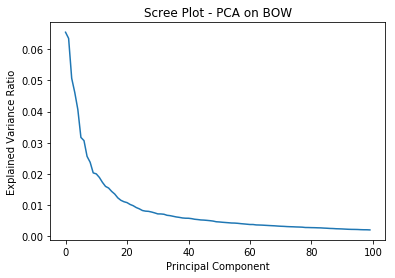

In [457]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot - PCA on BOW')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

### --- 1a. KMeans

Text(0, 0.5, 'Sum of squared distance')

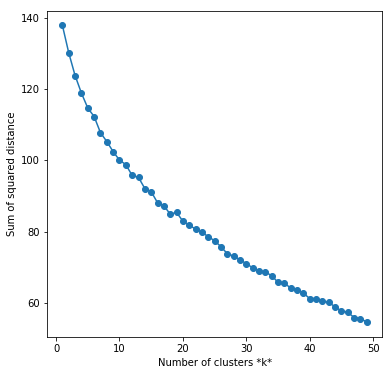

In [379]:
# Using elbow method to to optimize the number of clusters vs. clustering based on the number of authors in the pruned dataset
from sklearn.cluster import KMeans

sse = []
list_k = list(range(1, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state = 50)
    km.fit(train_bob_pca)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Passed 10 clusters, the rate of change for slope of the SSE decreases significanly, as the number of clusters increases without showing strongly sharp elbow. Arguably, the "elbow" of this SSE curve occurs anywhere between 10 and 30 clusters, and since the number of authors in the pruned dataset lies between these two cluster numbers, we'll cluster based on the number of authors.

Text(0, 0.5, 'Silhouette Score')

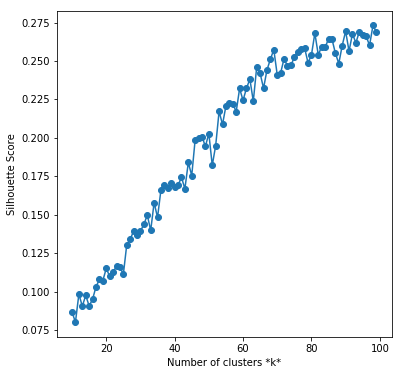

In [382]:
# Silhouette Analysis
from sklearn.metrics import silhouette_score

silhouette_vals = []
list_k = list(range(10, 100))

for k in list_k:
    km = KMeans(n_clusters=k, random_state = 50)
    cluster_labels = km.fit_predict(train_bob_pca)
    sil_score = silhouette_score(train_bob_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

The silhouette score increases pseudo-monotonically as the number of clusters increases. There  doesn't seem to be any definitive clustering pattern that KMeans is able to create besides splitting Bible book chapters into smaller and smaller groups. Below, we will go ahead and cluster based on the number of authors in the data set to what the clusters groups the chapters together.

In [438]:
# implementing K-means Clustering
from sklearn.cluster import KMeans

n_clusters = bible_pruned['author'].nunique()

kmeans = KMeans(n_clusters = n_clusters, random_state = 30)
kmeans.fit(train_bob_pca)
km_train_clusts = kmeans.predict(train_bob_pca)
km_test_clusts = kmeans.predict(test_bob_pca)

In [439]:
# matching clusters to text their features
km_train_clusters_df = train_set.copy()
km_train_clusters_df['cluster'] = km_train_clusts

km_test_clusters_df = test_set.copy()
km_test_clusters_df['cluster'] = km_test_clusts

# Printing all clusters
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(km_train_clusters_df[km_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])
    

Cluster # 0


,book_chapter,author,testament
447,Job 12,Job,OT


Cluster # 1


,book_chapter,author,testament
1056,Revelation 10,John,NT
780,Ezekiel 33,Ezekiel,OT
3,Genesis 4,Moses,OT
15,Genesis 16,Moses,OT
778,Ezekiel 31,Ezekiel,OT
29,Genesis 30,Moses,OT
1050,Revelation 4,John,NT
766,Ezekiel 19,Ezekiel,OT
961,Romans 9,Paul,NT
804,Daniel 9,Daniel,OT


Cluster # 2


,book_chapter,author,testament
913,John 10,John,NT
913,John 10,John,NT
917,John 14,John,NT
917,John 14,John,NT


Cluster # 3


,book_chapter,author,testament
565,Psalms 122,David,OT
571,Psalms 141,David,OT
734,Jeremiah 44,Jeremiah,OT
719,Jeremiah 29,Jeremiah,OT
713,Jeremiah 23,Jeremiah,OT
814,Hosea 7,Hosea,OT
385,2 Chronicles 19,Ezra,OT
557,Psalms 87,Sons of Korah,OT
574,Psalms 144,David,OT
563,Psalms 109,David,OT


Cluster # 4


,book_chapter,author,testament
426,Esther 1,Mordecai,OT
282,2 Samuel 16,Samuel,OT
800,Daniel 5,Daniel,OT
196,Joshua 10,Joshua,OT
310,1 Kings 20,Jeremiah,OT
300,1 Kings 10,Jeremiah,OT
644,Isaiah 20,Isaiah,OT
291,1 Kings 1,Jeremiah,OT
291,1 Kings 1,Jeremiah,OT
284,2 Samuel 18,Samuel,OT


Cluster # 5


,book_chapter,author,testament
1026,1 Timothy 1,Paul,NT
978,1 Corinthians 10,Paul,NT
1004,Ephesians 1,Paul,NT
1008,Ephesians 5,Paul,NT
1041,1 John 2,John,NT
969,1 Corinthians 1,Paul,NT
1025,2 Thessalonians 3,Paul,NT
1006,Ephesians 3,Paul,NT
1001,Galatians 4,Paul,NT
1012,Philippians 3,Paul,NT


Cluster # 6


,book_chapter,author,testament
85,Exodus 36,Moses,OT
86,Exodus 37,Moses,OT
296,1 Kings 6,Jeremiah,OT
296,1 Kings 6,Jeremiah,OT


Cluster # 7


,book_chapter,author,testament
204,Joshua 18,Joshua,OT
201,Joshua 15,Joshua,OT
203,Joshua 17,Joshua,OT
205,Joshua 19,Joshua,OT
205,Joshua 19,Joshua,OT


Cluster # 8


,book_chapter,author,testament
361,1 Chronicles 24,Ezra,OT
344,1 Chronicles 7,Ezra,OT
377,2 Chronicles 11,Ezra,OT
409,Ezra 7,Ezra,OT
45,Genesis 46,Moses,OT
342,1 Chronicles 5,Ezra,OT
35,Genesis 36,Moses,OT
142,Numbers 26,Moses,OT
412,Ezra 10,Ezra,OT
409,Ezra 7,Ezra,OT


Cluster # 9


,book_chapter,author,testament
74,Exodus 25,Moses,OT
175,Deuteronomy 23,Moses,OT
555,Psalms 85,Sons of Korah,OT
840,Matthew 5,Matthew,NT
27,Genesis 28,Moses,OT
171,Deuteronomy 19,Moses,OT
737,Jeremiah 47,Jeremiah,OT
174,Deuteronomy 22,Moses,OT
597,Proverbs 22,Solomon,OT
440,Job 5,Job,OT


Cluster # 10


,book_chapter,author,testament
256,1 Samuel 21,Samuel,OT
357,1 Chronicles 20,Ezra,OT
278,2 Samuel 12,Samuel,OT
265,1 Samuel 30,Samuel,OT
265,1 Samuel 30,Samuel,OT
265,1 Samuel 30,Samuel,OT
348,1 Chronicles 11,Ezra,OT


Cluster # 11


,book_chapter,author,testament
519,Psalms 46,Sons of Korah,OT
519,Psalms 46,Sons of Korah,OT
554,Psalms 84,Sons of Korah,OT
1043,1 John 4,John,NT
552,Psalms 82,Asaph,OT


Cluster # 12


,book_chapter,author,testament
127,Numbers 11,Moses,OT
84,Exodus 35,Moses,OT
129,Numbers 13,Moses,OT
213,Judges 3,Samuel,OT
126,Numbers 10,Moses,OT
152,Numbers 36,Moses,OT
134,Numbers 18,Moses,OT
231,Judges 21,Samuel,OT
65,Exodus 16,Moses,OT
137,Numbers 21,Moses,OT


Cluster # 13


,book_chapter,author,testament
268,2 Samuel 2,Samuel,OT
254,1 Samuel 19,Samuel,OT
257,1 Samuel 22,Samuel,OT
251,1 Samuel 16,Samuel,OT
347,1 Chronicles 10,Ezra,OT
263,1 Samuel 28,Samuel,OT
266,1 Samuel 31,Samuel,OT


Cluster # 14


,book_chapter,author,testament
288,2 Samuel 22,Samuel,OT
1048,Revelation 2,John,NT
445,Job 10,Job,OT
617,Song of Solomon 1,Solomon,OT
479,Psalms 3,David,OT
524,Psalms 51,David,OT
533,Psalms 60,David,OT
524,Psalms 51,David,OT
485,Psalms 9,David,OT
540,Psalms 69,David,OT


Cluster # 15


,book_chapter,author,testament
653,Isaiah 29,Isaiah,OT
585,Proverbs 10,Solomon,OT
104,Leviticus 15,Moses,OT
121,Numbers 5,Moses,OT
806,Daniel 11,Daniel,OT
452,Job 17,Job,OT
104,Leviticus 15,Moses,OT
452,Job 17,Job,OT
616,Ecclesiastes 12,Solomon,OT
628,Isaiah 4,Isaiah,OT


Cluster # 16


,book_chapter,author,testament
438,Job 3,Job,OT
444,Job 9,Job,OT
606,Ecclesiastes 2,Solomon,OT
606,Ecclesiastes 2,Solomon,OT
670,Isaiah 46,Isaiah,OT
996,2 Corinthians 12,Paul,NT
583,Proverbs 8,Solomon,OT
959,Romans 7,Paul,NT
995,2 Corinthians 11,Paul,NT


Cluster # 17


,book_chapter,author,testament
425,Nehemiah 13,Nehemiah,OT
422,Nehemiah 10,Nehemiah,OT
422,Nehemiah 10,Nehemiah,OT
401,2 Chronicles 35,Ezra,OT


Cluster # 18


,book_chapter,author,testament
91,Leviticus 2,Moses,OT
91,Leviticus 2,Moses,OT
793,Ezekiel 46,Ezekiel,OT
96,Leviticus 7,Moses,OT


Cluster # 19


,book_chapter,author,testament
595,Proverbs 20,Solomon,OT
595,Proverbs 20,Solomon,OT
460,Job 25,Job,OT


Cluster # 20


,book_chapter,author,testament
36,Genesis 37,Moses,OT
928,Acts of the Apostles 4,Luke,NT
935,Acts of the Apostles 11,Luke,NT
226,Judges 16,Samuel,OT
944,Acts of the Apostles 20,Luke,NT
896,Luke 17,Luke,NT
896,Luke 17,Luke,NT
884,Luke 5,Luke,NT
901,Luke 22,Luke,NT
929,Acts of the Apostles 5,Luke,NT


Cluster # 21


,book_chapter,author,testament
607,Ecclesiastes 3,Solomon,OT


In [440]:
# Printing clusters for test set
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(km_test_clusters_df[km_test_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament


Cluster # 1


,book_chapter,author,testament
1064,Revelation 18,John,NT
1067,Revelation 21,John,NT
1028,1 Timothy 3,Paul,NT
17,Genesis 18,Moses,OT
1058,Revelation 12,John,NT
24,Genesis 25,Moses,OT
22,Genesis 23,Moses,OT
461,Job 26,Job,OT
46,Genesis 47,Moses,OT
7,Genesis 8,Moses,OT


Cluster # 2


,book_chapter,author,testament
919,John 16,John,NT


Cluster # 3


,book_chapter,author,testament
380,2 Chronicles 14,Ezra,OT
232,Ruth 1,Samuel,OT
762,Ezekiel 15,Ezekiel,OT
809,Hosea 2,Hosea,OT
632,Isaiah 8,Isaiah,OT
829,Zechariah 8,Zechariah,OT
576,Proverbs 1,Solomon,OT
675,Isaiah 51,Isaiah,OT
334,2 Kings 22,Jeremiah,OT
735,Jeremiah 45,Jeremiah,OT


Cluster # 4


,book_chapter,author,testament
293,1 Kings 3,Jeremiah,OT
292,1 Kings 2,Jeremiah,OT
393,2 Chronicles 27,Ezra,OT
801,Daniel 6,Daniel,OT
330,2 Kings 18,Jeremiah,OT
13,Genesis 14,Moses,OT
312,1 Kings 22,Jeremiah,OT
391,2 Chronicles 25,Ezra,OT
319,2 Kings 7,Jeremiah,OT
389,2 Chronicles 23,Ezra,OT


Cluster # 5


,book_chapter,author,testament
997,2 Corinthians 13,Paul,NT
976,1 Corinthians 8,Paul,NT
986,2 Corinthians 2,Paul,NT
1003,Galatians 6,Paul,NT
983,1 Corinthians 15,Paul,NT
974,1 Corinthians 6,Paul,NT
988,2 Corinthians 4,Paul,NT
1007,Ephesians 4,Paul,NT
958,Romans 6,Paul,NT
985,2 Corinthians 1,Paul,NT


Cluster # 6


,book_chapter,author,testament
369,2 Chronicles 3,Ezra,OT
787,Ezekiel 40,Ezekiel,OT
370,2 Chronicles 4,Ezra,OT


Cluster # 7


,book_chapter,author,testament
150,Numbers 34,Moses,OT


Cluster # 8


,book_chapter,author,testament
423,Nehemiah 11,Nehemiah,OT
338,1 Chronicles 1,Ezra,OT
730,Jeremiah 40,Jeremiah,OT


Cluster # 9


,book_chapter,author,testament
474,Job 39,Job,OT
785,Ezekiel 38,Ezekiel,OT
234,Ruth 3,Samuel,OT
549,Psalms 79,Asaph,OT
173,Deuteronomy 21,Moses,OT
180,Deuteronomy 28,Moses,OT
449,Job 14,Job,OT
577,Proverbs 2,Solomon,OT
172,Deuteronomy 20,Moses,OT
578,Proverbs 3,Solomon,OT


Cluster # 10


,book_chapter,author,testament
355,1 Chronicles 18,Ezra,OT
260,1 Samuel 25,Samuel,OT
350,1 Chronicles 13,Ezra,OT
272,2 Samuel 6,Samuel,OT


Cluster # 11


,book_chapter,author,testament
0,Genesis 1,Moses,OT
955,Romans 3,Paul,NT


Cluster # 12


,book_chapter,author,testament
420,Nehemiah 8,Nehemiah,OT
117,Numbers 1,Moses,OT
220,Judges 10,Samuel,OT
221,Judges 11,Samuel,OT
128,Numbers 12,Moses,OT
148,Numbers 32,Moses,OT
61,Exodus 12,Moses,OT
120,Numbers 4,Moses,OT
68,Exodus 19,Moses,OT
66,Exodus 17,Moses,OT


Cluster # 13


,book_chapter,author,testament
259,1 Samuel 24,Samuel,OT


Cluster # 14


,book_chapter,author,testament
515,Psalms 41,David,OT
553,Psalms 83,Asaph,OT
483,Psalms 7,David,OT
451,Job 16,Job,OT
544,Psalms 74,Asaph,OT
745,Lamentations 3,Jeremiah,OT
573,Psalms 143,David,OT
497,Psalms 22,David,OT
527,Psalms 54,David,OT
465,Job 30,Job,OT


Cluster # 15


,book_chapter,author,testament
586,Proverbs 11,Solomon,OT
679,Isaiah 55,Isaiah,OT
643,Isaiah 19,Isaiah,OT
603,Proverbs 28,Solomon,OT
110,Leviticus 21,Moses,OT
453,Job 18,Job,OT
655,Isaiah 31,Isaiah,OT
876,Mark 13,John Mark,NT
795,Ezekiel 48,Ezekiel,OT
658,Isaiah 34,Isaiah,OT


Cluster # 16


,book_chapter,author,testament
984,1 Corinthians 16,Paul,NT
999,Galatians 2,Paul,NT
608,Ecclesiastes 4,Solomon,OT
611,Ecclesiastes 7,Solomon,OT


Cluster # 17


,book_chapter,author,testament
405,Ezra 3,Ezra,OT


Cluster # 18


,book_chapter,author,testament
131,Numbers 15,Moses,OT
144,Numbers 28,Moses,OT
145,Numbers 29,Moses,OT
79,Exodus 30,Moses,OT
112,Leviticus 23,Moses,OT


Cluster # 19


,book_chapter,author,testament
593,Proverbs 18,Solomon,OT
596,Proverbs 21,Solomon,OT


Cluster # 20


,book_chapter,author,testament
456,Job 21,Job,OT
864,Mark 1,John Mark,NT
303,1 Kings 13,Jeremiah,OT
925,Acts of the Apostles 1,Luke,NT
887,Luke 8,Luke,NT
839,Matthew 4,Matthew,NT
898,Luke 19,Luke,NT
883,Luke 4,Luke,NT
947,Acts of the Apostles 23,Luke,NT
32,Genesis 33,Moses,OT


Cluster # 21


,book_chapter,author,testament


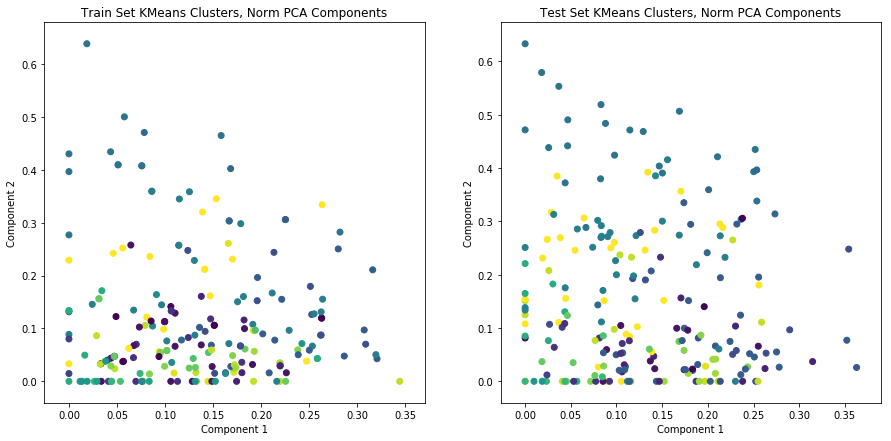

In [386]:
# Visualizing the clusters based on the first two PCA components
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
plt.scatter(train_bob_norm[:,0], train_bob_norm[:,1], c = km_train_clusts)
plt.title('Train Set KMeans Clusters, Norm PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1,2,2)
plt.scatter(test_bob_norm[:,0], test_bob_norm[:,1], c = km_test_clusts)
plt.title('Test Set KMeans Clusters, Norm PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Visually the clusters overlap significantly; the first two components, afterall, only capture around 12% of the variance of full dimensinoality of the data set. The entire PCA transformation extracts 100 PC's that contribute to the final clustering dimension of the train_set, so clustering in the higher dimensions probably creates more delineated clusters. Visuializing in 2 dimensions however is only useful insofar as it shows that the clusters aren't easily .

### --- 1b. Mean Shift

In [396]:
bandwidth_estimate = estimate_bandwidth(train_bob_pca, quantile = 0.5)

1.1402578591305412

In [412]:
# Using elbow method to to optimize the number of clusters vs. clustering based on the number of authors in the pruned dataset
from sklearn.cluster import MeanShift, estimate_bandwidth

q_list = [q/10 for q in list(range(10, 11))]
silhouette_vals = []

for q in q_list:
    bandwidth_estimate = estimate_bandwidth(train_bob_pca, quantile = q)

    ms = MeanShift(bandwidth = bandwidth_estimate, bin_seeding = True)
    ms.fit(train_bob_pca)
    cluster_labels = ms.labels_
    
    sil_score = silhouette_score(train_bob_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot silhouette against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

According to the error message above, the silhouette score cannot be calculated because the meanshift clustering model can't seem to create more than one cluster. Toggling with the bandwidth estimator with quantiles ranging between 0 and 1, the number of clusters created never exceeds more than one. So mean shift will not work as a clustering method.

### --- 1c. Spectral Affinity

Text(0, 0.5, 'Silhouette Score')

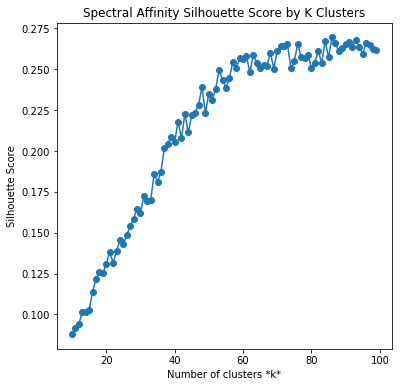

In [416]:
from sklearn.cluster import SpectralClustering

silhouette_vals = []
list_k = list(range(10, 100))

for k in list_k:
    sc = SpectralClustering(n_clusters=k, random_state = 50)
    cluster_labels = sc.fit_predict(train_bob_pca)
    sil_score = silhouette_score(train_bob_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.title('Spectral Affinity Silhouette Score by K Clusters')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

Essentially the same issue with KMeans Clustering. At this point, it seems that the best clustering is the arbitrary decision to choose the clusters based on the number of authors in the data set (22 clusters).

Or for exploratory purposed, we can set the clusters numbers at the 'elbow' of the above silhouette graph (k = 60) and see what the spectral affinity clusters returns.

In [417]:
n_clusters = bible_pruned['author'].nunique()

spec = SpectralClustering(n_clusters = n_clusters, random_state = 30)
spec_train_clusts = spec.fit_predict(train_bob_norm)

# matching clusters to text their features
spec_train_clusters_df = train_set.copy()
spec_train_clusters_df['cluster'] = spec_train_clusts

# Printing all clusters
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(spec_train_clusters_df[spec_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
265,1 Samuel 30,Samuel,OT
265,1 Samuel 30,Samuel,OT
265,1 Samuel 30,Samuel,OT


Cluster # 1


,book_chapter,author,testament
127,Numbers 11,Moses,OT
84,Exodus 35,Moses,OT
154,Deuteronomy 2,Moses,OT
129,Numbers 13,Moses,OT
196,Joshua 10,Joshua,OT
213,Judges 3,Samuel,OT
126,Numbers 10,Moses,OT
152,Numbers 36,Moses,OT
203,Joshua 17,Joshua,OT
58,Exodus 9,Moses,OT


Cluster # 2


,book_chapter,author,testament
913,John 10,John,NT
913,John 10,John,NT
917,John 14,John,NT
1041,1 John 2,John,NT
1001,Galatians 4,Paul,NT
917,John 14,John,NT


Cluster # 3


,book_chapter,author,testament
361,1 Chronicles 24,Ezra,OT
344,1 Chronicles 7,Ezra,OT
45,Genesis 46,Moses,OT
342,1 Chronicles 5,Ezra,OT
35,Genesis 36,Moses,OT
142,Numbers 26,Moses,OT
412,Ezra 10,Ezra,OT


Cluster # 4


,book_chapter,author,testament
734,Jeremiah 44,Jeremiah,OT
719,Jeremiah 29,Jeremiah,OT
713,Jeremiah 23,Jeremiah,OT
385,2 Chronicles 19,Ezra,OT
385,2 Chronicles 19,Ezra,OT
708,Jeremiah 18,Jeremiah,OT
737,Jeremiah 47,Jeremiah,OT
378,2 Chronicles 12,Ezra,OT
723,Jeremiah 33,Jeremiah,OT
377,2 Chronicles 11,Ezra,OT


Cluster # 5


,book_chapter,author,testament
565,Psalms 122,David,OT
256,1 Samuel 21,Samuel,OT
3,Genesis 4,Moses,OT
268,2 Samuel 2,Samuel,OT
357,1 Chronicles 20,Ezra,OT
15,Genesis 16,Moses,OT
226,Judges 16,Samuel,OT
27,Genesis 28,Moses,OT
282,2 Samuel 16,Samuel,OT
254,1 Samuel 19,Samuel,OT


Cluster # 6


,book_chapter,author,testament
36,Genesis 37,Moses,OT
928,Acts of the Apostles 4,Luke,NT
935,Acts of the Apostles 11,Luke,NT
814,Hosea 7,Hosea,OT
944,Acts of the Apostles 20,Luke,NT
896,Luke 17,Luke,NT
896,Luke 17,Luke,NT
884,Luke 5,Luke,NT
901,Luke 22,Luke,NT
929,Acts of the Apostles 5,Luke,NT


Cluster # 7


,book_chapter,author,testament
347,1 Chronicles 10,Ezra,OT
266,1 Samuel 31,Samuel,OT


Cluster # 8


,book_chapter,author,testament
296,1 Kings 6,Jeremiah,OT
296,1 Kings 6,Jeremiah,OT


Cluster # 9


,book_chapter,author,testament
175,Deuteronomy 23,Moses,OT
653,Isaiah 29,Isaiah,OT
780,Ezekiel 33,Ezekiel,OT
840,Matthew 5,Matthew,NT
585,Proverbs 10,Solomon,OT
104,Leviticus 15,Moses,OT
720,Jeremiah 30,Jeremiah,OT
121,Numbers 5,Moses,OT
171,Deuteronomy 19,Moses,OT
806,Daniel 11,Daniel,OT


Cluster # 10


,book_chapter,author,testament
91,Leviticus 2,Moses,OT
91,Leviticus 2,Moses,OT
793,Ezekiel 46,Ezekiel,OT
96,Leviticus 7,Moses,OT


Cluster # 11


,book_chapter,author,testament
1056,Revelation 10,John,NT
447,Job 12,Job,OT
557,Psalms 87,Sons of Korah,OT
1048,Revelation 2,John,NT
574,Psalms 144,David,OT
700,Jeremiah 10,Jeremiah,OT
665,Isaiah 41,Isaiah,OT
778,Ezekiel 31,Ezekiel,OT
1050,Revelation 4,John,NT
961,Romans 9,Paul,NT


Cluster # 12


,book_chapter,author,testament
204,Joshua 18,Joshua,OT
201,Joshua 15,Joshua,OT
205,Joshua 19,Joshua,OT
205,Joshua 19,Joshua,OT


Cluster # 13


,book_chapter,author,testament
571,Psalms 141,David,OT
438,Job 3,Job,OT
563,Psalms 109,David,OT
571,Psalms 141,David,OT
540,Psalms 69,David,OT


Cluster # 14


,book_chapter,author,testament
519,Psalms 46,Sons of Korah,OT
519,Psalms 46,Sons of Korah,OT


Cluster # 15


,book_chapter,author,testament
425,Nehemiah 13,Nehemiah,OT
422,Nehemiah 10,Nehemiah,OT
422,Nehemiah 10,Nehemiah,OT
409,Ezra 7,Ezra,OT
401,2 Chronicles 35,Ezra,OT
407,Ezra 5,Ezra,OT
409,Ezra 7,Ezra,OT


Cluster # 16


,book_chapter,author,testament
1026,1 Timothy 1,Paul,NT
978,1 Corinthians 10,Paul,NT
1004,Ephesians 1,Paul,NT
1008,Ephesians 5,Paul,NT
969,1 Corinthians 1,Paul,NT
1025,2 Thessalonians 3,Paul,NT
1006,Ephesians 3,Paul,NT
1012,Philippians 3,Paul,NT
1002,Galatians 5,Paul,NT


Cluster # 17


,book_chapter,author,testament
444,Job 9,Job,OT
606,Ecclesiastes 2,Solomon,OT
606,Ecclesiastes 2,Solomon,OT
670,Isaiah 46,Isaiah,OT
996,2 Corinthians 12,Paul,NT
959,Romans 7,Paul,NT
995,2 Corinthians 11,Paul,NT


Cluster # 18


,book_chapter,author,testament
288,2 Samuel 22,Samuel,OT
555,Psalms 85,Sons of Korah,OT
445,Job 10,Job,OT
617,Song of Solomon 1,Solomon,OT
479,Psalms 3,David,OT
524,Psalms 51,David,OT
533,Psalms 60,David,OT
524,Psalms 51,David,OT
485,Psalms 9,David,OT
516,Psalms 42,Sons of Korah,OT


Cluster # 19


,book_chapter,author,testament
426,Esther 1,Mordecai,OT
800,Daniel 5,Daniel,OT
300,1 Kings 10,Jeremiah,OT
644,Isaiah 20,Isaiah,OT
291,1 Kings 1,Jeremiah,OT
291,1 Kings 1,Jeremiah,OT
284,2 Samuel 18,Samuel,OT
280,2 Samuel 14,Samuel,OT
435,Esther 10,Mordecai,OT
727,Jeremiah 37,Jeremiah,OT


Cluster # 20


,book_chapter,author,testament
74,Exodus 25,Moses,OT
85,Exodus 36,Moses,OT
86,Exodus 37,Moses,OT


Cluster # 21


,book_chapter,author,testament
595,Proverbs 20,Solomon,OT
469,Job 34,Job,OT
595,Proverbs 20,Solomon,OT
469,Job 34,Job,OT
460,Job 25,Job,OT


Looking at this training set clustering, I realize that when the training set is being resampled, I need to set the replacement setting to False.

## 2. TF-IDF Feature Clustering

In [421]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting the data set into train and test sets. PP means preprocessed.
# The original train and test sets (from BOW analysis) won't be used for this feature generation method in order to model more of the data
train_set_PP, test_set_PP = train_test_split(bible_pruned, train_size = 0.75, random_state = 7)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Fitting to the train set, and transforming both sets with train fitted model.
train_set_tfidf = vectorizer.fit_transform(train_set_PP.token_text)
test_set_tfidf = vectorizer.transform(test_set_PP.token_text)

# Normalizing tfidf rows before dimension reduction
train_tfidf_norm = normalize(train_set_tfidf)
test_tfidf_norm = normalize(test_set_tfidf)


(801, 600)
(268, 600)
0.9191720341818026


Text(0, 0.5, 'Explained Variance Ratio')

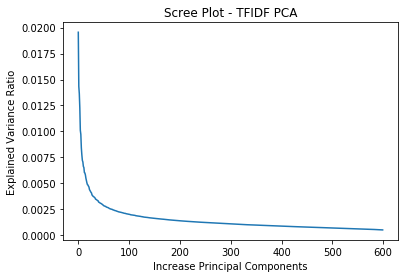

In [436]:
# PCA Dimension Reduction
pca = PCA(600)
pca.fit(train_tfidf_norm.todense())
train_tfidf_pca = pca.transform(train_tfidf_norm.todense())
test_tfidf_pca = pca.transform(test_tfidf_norm.todense())

print(train_tfidf_pca.shape)
print(test_tfidf_pca.shape)
#print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot - TFIDF PCA')
plt.xlabel('Increase Principal Components')
plt.ylabel('Explained Variance Ratio')

Although the scree plot of the principal components of the TF-IDF has a defined elbow when a large number of components are mapped out, even the intial components start with small varianace ratios. We will use 600 principal components because computation is not very expensive for clustering, and it's ideal to have above at least 90% of the variance captured by the principal components.

In [432]:
# Testing out PCA with and without normalizing; the EVR is just about the same without normalizing.

# PCA Dimension Reduction
#pca = PCA(600)
#pca.fit(train_set_tfidf.todense())
#train_tfidf_pca = pca.transform(train_set_tfidf.todense())
#test_tfidf_pca = pca.transform(test_set_tfidf.todense())

#print(pca.explained_variance_ratio_)
#pca.explained_variance_ratio_.sum()

0.9190817753737629

### --- 2a. KMeans

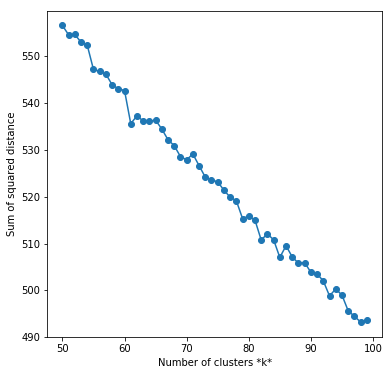

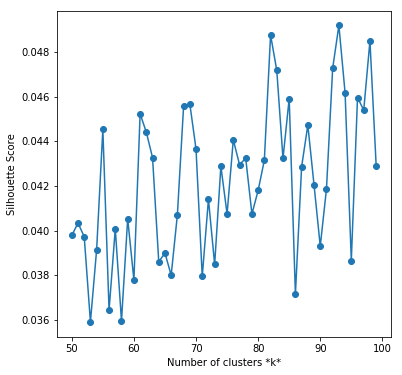

In [437]:
# Sum of squared distance and Silhouette analysis
sse = []
silhouette_vals = []
list_k = list(range(50, 100))

for k in list_k:
    # Fitting the models
    km = KMeans(n_clusters=k, random_state = 50)  
    km.fit(train_tfidf_pca)
    
    # Appending corresponding SSE to list
    sse.append(km.inertia_)
    
    # Appending corresponding Silhouette Score to list
    cluster_labels = km.fit_predict(train_tfidf_pca)
    sil_score = silhouette_score(train_tfidf_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# SSE Plot against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

# Silhouette Plot against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.show()

The silhouette and sum of squared distances graphs don't indicate that there is an optimal cluster count. Both show monotonic behavior without any indication of a global minima or maxima. Also the noise in the graphs are probably simply due to the random intial conditions of KMeans to pick arbitray intial centroid locations.

Below we will analyze the clusters based on the number of authors in the pruned dataset. (k=22) Fewer clusters makes will be easier to look into.

In [613]:
# KMeans, Looking into the clusters
n_clusters = 100 #bible_pruned['author'].nunique()

kmeans = KMeans(n_clusters = n_clusters, random_state = 30)
kmeans.fit(train_tfidf_pca)
km_train_clusts = kmeans.predict(train_tfidf_pca)
km_test_clusts = kmeans.predict(test_tfidf_pca)

# matching clusters to text their features
km_train_clusters_df = train_set_PP.copy()
km_train_clusters_df['cluster'] = km_train_clusts

km_test_clusters_df = test_set_PP.copy()
km_test_clusters_df['cluster'] = km_test_clusts

# Printing all clusters
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(km_train_clusters_df[km_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
327,2 Kings 15,Jeremiah,OT
387,2 Chronicles 21,Ezra,OT
390,2 Chronicles 24,Ezra,OT
381,2 Chronicles 15,Ezra,OT
333,2 Kings 21,Jeremiah,OT
382,2 Chronicles 16,Ezra,OT
392,2 Chronicles 26,Ezra,OT
394,2 Chronicles 28,Ezra,OT
383,2 Chronicles 17,Ezra,OT
380,2 Chronicles 14,Ezra,OT


Cluster # 1


,book_chapter,author,testament
578,Proverbs 3,Solomon,OT
577,Proverbs 2,Solomon,OT
580,Proverbs 5,Solomon,OT
583,Proverbs 8,Solomon,OT
584,Proverbs 9,Solomon,OT
576,Proverbs 1,Solomon,OT
579,Proverbs 4,Solomon,OT


Cluster # 2


,book_chapter,author,testament
960,Romans 8,Paul,NT
962,Romans 10,Paul,NT
959,Romans 7,Paul,NT
961,Romans 9,Paul,NT
958,Romans 6,Paul,NT
956,Romans 4,Paul,NT
1002,Galatians 5,Paul,NT
1000,Galatians 3,Paul,NT
954,Romans 2,Paul,NT
977,1 Corinthians 9,Paul,NT


Cluster # 3


,book_chapter,author,testament
926,Acts of the Apostles 2,Luke,NT
933,Acts of the Apostles 9,Luke,NT
929,Acts of the Apostles 5,Luke,NT
927,Acts of the Apostles 3,Luke,NT
928,Acts of the Apostles 4,Luke,NT
930,Acts of the Apostles 6,Luke,NT


Cluster # 4


,book_chapter,author,testament
483,Psalms 7,David,OT
571,Psalms 141,David,OT
508,Psalms 34,David,OT
504,Psalms 29,David,OT
510,Psalms 36,David,OT
515,Psalms 41,David,OT
542,Psalms 72,Solomon,OT
501,Psalms 26,David,OT
574,Psalms 144,David,OT
561,Psalms 103,David,OT


Cluster # 5


,book_chapter,author,testament
365,1 Chronicles 28,Ezra,OT
359,1 Chronicles 22,Ezra,OT
368,2 Chronicles 2,Ezra,OT
366,1 Chronicles 29,Ezra,OT


Cluster # 6


,book_chapter,author,testament
357,1 Chronicles 20,Ezra,OT
271,2 Samuel 5,Samuel,OT
277,2 Samuel 11,Samuel,OT
289,2 Samuel 23,Samuel,OT
355,1 Chronicles 18,Ezra,OT
278,2 Samuel 12,Samuel,OT
286,2 Samuel 20,Samuel,OT
274,2 Samuel 8,Samuel,OT
348,1 Chronicles 11,Ezra,OT
265,1 Samuel 30,Samuel,OT


Cluster # 7


,book_chapter,author,testament
981,1 Corinthians 13,Paul,NT
1027,1 Timothy 2,Paul,NT
1031,1 Timothy 6,Paul,NT
1046,3 John 1,John,NT
1035,2 Timothy 4,Paul,NT
1034,2 Timothy 3,Paul,NT
1028,1 Timothy 3,Paul,NT
1033,2 Timothy 2,Paul,NT
1038,Titus 3,Paul,NT
1036,Titus 1,Paul,NT


Cluster # 8


,book_chapter,author,testament
696,Jeremiah 6,Jeremiah,OT
411,Ezra 9,Ezra,OT
732,Jeremiah 42,Jeremiah,OT
704,Jeremiah 14,Jeremiah,OT
804,Daniel 9,Daniel,OT
708,Jeremiah 18,Jeremiah,OT
746,Lamentations 4,Jeremiah,OT
695,Jeremiah 5,Jeremiah,OT
692,Jeremiah 2,Jeremiah,OT
688,Isaiah 64,Isaiah,OT


Cluster # 9


,book_chapter,author,testament
209,Joshua 23,Joshua,OT
212,Judges 2,Samuel,OT
210,Joshua 24,Joshua,OT
824,Zechariah 3,Zechariah,OT


Cluster # 10


,book_chapter,author,testament
30,Genesis 31,Moses,OT
28,Genesis 29,Moses,OT
29,Genesis 30,Moses,OT


Cluster # 11


,book_chapter,author,testament
89,Exodus 40,Moses,OT
79,Exodus 30,Moses,OT
78,Exodus 29,Moses,OT


Cluster # 12


,book_chapter,author,testament
843,Matthew 8,Matthew,NT
854,Matthew 19,Matthew,NT
872,Mark 9,John Mark,NT
851,Matthew 16,Matthew,NT
855,Matthew 20,Matthew,NT
873,Mark 10,John Mark,NT
850,Matthew 15,Matthew,NT
888,Luke 9,Luke,NT
884,Luke 5,Luke,NT
844,Matthew 9,Matthew,NT


Cluster # 13


,book_chapter,author,testament
703,Jeremiah 13,Jeremiah,OT
739,Jeremiah 49,Jeremiah,OT
706,Jeremiah 16,Jeremiah,OT
699,Jeremiah 9,Jeremiah,OT
697,Jeremiah 7,Jeremiah,OT
725,Jeremiah 35,Jeremiah,OT
701,Jeremiah 11,Jeremiah,OT
709,Jeremiah 19,Jeremiah,OT
833,Zechariah 12,Zechariah,OT
707,Jeremiah 17,Jeremiah,OT


Cluster # 14


,book_chapter,author,testament
71,Exodus 22,Moses,OT
70,Exodus 21,Moses,OT
177,Deuteronomy 25,Moses,OT
37,Genesis 38,Moses,OT
174,Deuteronomy 22,Moses,OT
173,Deuteronomy 21,Moses,OT
176,Deuteronomy 24,Moses,OT
809,Hosea 2,Hosea,OT
107,Leviticus 18,Moses,OT


Cluster # 15


,book_chapter,author,testament
778,Ezekiel 31,Ezekiel,OT
963,Romans 11,Paul,NT
821,Hosea 14,Hosea,OT
766,Ezekiel 19,Ezekiel,OT
826,Zechariah 5,Zechariah,OT
1,Genesis 2,Moses,OT
832,Zechariah 11,Zechariah,OT
762,Ezekiel 15,Ezekiel,OT
764,Ezekiel 17,Ezekiel,OT


Cluster # 16


,book_chapter,author,testament
435,Esther 10,Mordecai,OT
431,Esther 6,Mordecai,OT
432,Esther 7,Mordecai,OT
429,Esther 4,Mordecai,OT
433,Esther 8,Mordecai,OT
427,Esther 2,Mordecai,OT
428,Esther 3,Mordecai,OT
434,Esther 9,Mordecai,OT


Cluster # 17


,book_chapter,author,testament
127,Numbers 11,Moses,OT
147,Numbers 31,Moses,OT
81,Exodus 32,Moses,OT
66,Exodus 17,Moses,OT
132,Numbers 16,Moses,OT
65,Exodus 16,Moses,OT
82,Exodus 33,Moses,OT
133,Numbers 17,Moses,OT
187,Joshua 1,Joshua,OT
136,Numbers 20,Moses,OT


Cluster # 18


,book_chapter,author,testament
64,Exodus 15,Moses,OT
491,Psalms 16,David,OT
493,Psalms 18,David,OT
478,Psalms 2,David,OT
505,Psalms 30,David,OT
543,Psalms 73,Asaph,OT
538,Psalms 65,David,OT
496,Psalms 21,David,OT
533,Psalms 60,David,OT
559,Psalms 90,Moses,OT


Cluster # 19


,book_chapter,author,testament
937,Acts of the Apostles 13,Luke,NT
943,Acts of the Apostles 19,Luke,NT
952,Acts of the Apostles 28,Luke,NT
941,Acts of the Apostles 17,Luke,NT
948,Acts of the Apostles 24,Luke,NT
947,Acts of the Apostles 23,Luke,NT
939,Acts of the Apostles 15,Luke,NT
942,Acts of the Apostles 18,Luke,NT
950,Acts of the Apostles 26,Luke,NT
938,Acts of the Apostles 14,Luke,NT


Cluster # 20


,book_chapter,author,testament
859,Matthew 24,Matthew,NT
974,1 Corinthians 6,Paul,NT
900,Luke 21,Luke,NT
115,Leviticus 26,Moses,OT
903,Luke 24,Luke,NT
979,1 Corinthians 11,Paul,NT
980,1 Corinthians 12,Paul,NT
982,1 Corinthians 14,Paul,NT
879,Mark 16,John Mark,NT
978,1 Corinthians 10,Paul,NT


Cluster # 21


,book_chapter,author,testament
251,1 Samuel 16,Samuel,OT
263,1 Samuel 28,Samuel,OT
245,1 Samuel 10,Samuel,OT
246,1 Samuel 11,Samuel,OT
250,1 Samuel 15,Samuel,OT


Cluster # 22


,book_chapter,author,testament
80,Exodus 31,Moses,OT
87,Exodus 38,Moses,OT
86,Exodus 37,Moses,OT
84,Exodus 35,Moses,OT
88,Exodus 39,Moses,OT
77,Exodus 28,Moses,OT
76,Exodus 27,Moses,OT
85,Exodus 36,Moses,OT


Cluster # 23


,book_chapter,author,testament
736,Jeremiah 46,Jeremiah,OT
50,Exodus 1,Moses,OT
40,Genesis 41,Moses,OT
62,Exodus 13,Moses,OT
45,Genesis 46,Moses,OT
39,Genesis 40,Moses,OT
931,Acts of the Apostles 7,Luke,NT


Cluster # 24


,book_chapter,author,testament
500,Psalms 25,David,OT
563,Psalms 109,David,OT
558,Psalms 88,Sons of Korah,OT
567,Psalms 131,David,OT
650,Isaiah 26,Isaiah,OT
512,Psalms 38,David,OT
516,Psalms 42,Sons of Korah,OT
549,Psalms 79,Asaph,OT
573,Psalms 143,David,OT
536,Psalms 63,David,OT


Cluster # 25


,book_chapter,author,testament
817,Hosea 10,Hosea,OT
644,Isaiah 20,Isaiah,OT
831,Zechariah 10,Zechariah,OT
329,2 Kings 17,Jeremiah,OT
814,Hosea 7,Hosea,OT
819,Hosea 12,Hosea,OT
811,Hosea 4,Hosea,OT
816,Hosea 9,Hosea,OT
631,Isaiah 7,Isaiah,OT


Cluster # 26


,book_chapter,author,testament
749,Ezekiel 2,Ezekiel,OT
775,Ezekiel 28,Ezekiel,OT
752,Ezekiel 5,Ezekiel,OT
781,Ezekiel 34,Ezekiel,OT
782,Ezekiel 35,Ezekiel,OT
768,Ezekiel 21,Ezekiel,OT
761,Ezekiel 14,Ezekiel,OT
754,Ezekiel 7,Ezekiel,OT
786,Ezekiel 39,Ezekiel,OT
758,Ezekiel 11,Ezekiel,OT


Cluster # 27


,book_chapter,author,testament
159,Deuteronomy 7,Moses,OT
167,Deuteronomy 15,Moses,OT
751,Ezekiel 4,Ezekiel,OT
72,Exodus 23,Moses,OT
69,Exodus 20,Moses,OT
169,Deuteronomy 17,Moses,OT
180,Deuteronomy 28,Moses,OT
175,Deuteronomy 23,Moses,OT


Cluster # 28


,book_chapter,author,testament
316,2 Kings 4,Jeremiah,OT
237,1 Samuel 2,Samuel,OT
894,Luke 15,Luke,NT
2,Genesis 3,Moses,OT
229,Judges 19,Samuel,OT
236,1 Samuel 1,Samuel,OT
116,Leviticus 27,Moses,OT
223,Judges 13,Samuel,OT
680,Isaiah 56,Isaiah,OT
860,Matthew 25,Matthew,NT


Cluster # 29


,book_chapter,author,testament
302,1 Kings 12,Jeremiah,OT
378,2 Chronicles 12,Ezra,OT
304,1 Kings 14,Jeremiah,OT
376,2 Chronicles 10,Ezra,OT


Cluster # 30


,book_chapter,author,testament
199,Joshua 13,Joshua,OT
202,Joshua 16,Joshua,OT
155,Deuteronomy 3,Moses,OT
794,Ezekiel 47,Ezekiel,OT
203,Joshua 17,Joshua,OT
201,Joshua 15,Joshua,OT
211,Judges 1,Samuel,OT


Cluster # 31


,book_chapter,author,testament
596,Proverbs 21,Solomon,OT
590,Proverbs 15,Solomon,OT
603,Proverbs 28,Solomon,OT
601,Proverbs 26,Solomon,OT
511,Psalms 37,David,OT
586,Proverbs 11,Solomon,OT
587,Proverbs 12,Solomon,OT
591,Proverbs 16,Solomon,OT
595,Proverbs 20,Solomon,OT
592,Proverbs 17,Solomon,OT


Cluster # 32


,book_chapter,author,testament
714,Jeremiah 24,Jeremiah,OT
728,Jeremiah 38,Jeremiah,OT
740,Jeremiah 50,Jeremiah,OT
715,Jeremiah 25,Jeremiah,OT
724,Jeremiah 34,Jeremiah,OT
717,Jeremiah 27,Jeremiah,OT
719,Jeremiah 29,Jeremiah,OT
727,Jeremiah 37,Jeremiah,OT
711,Jeremiah 21,Jeremiah,OT
710,Jeremiah 20,Jeremiah,OT


Cluster # 33


,book_chapter,author,testament
101,Leviticus 12,Moses,OT
135,Numbers 19,Moses,OT
103,Leviticus 14,Moses,OT
104,Leviticus 15,Moses,OT
102,Leviticus 13,Moses,OT
121,Numbers 5,Moses,OT


Cluster # 34


,book_chapter,author,testament
1067,Revelation 21,John,NT
1063,Revelation 17,John,NT
1061,Revelation 15,John,NT
1058,Revelation 12,John,NT


Cluster # 35


,book_chapter,author,testament
473,Job 38,Job,OT
454,Job 19,Job,OT
452,Job 17,Job,OT
471,Job 36,Job,OT
463,Job 28,Job,OT
446,Job 11,Job,OT
457,Job 22,Job,OT
466,Job 31,Job,OT
447,Job 12,Job,OT
602,Proverbs 27,Solomon,OT


Cluster # 36


,book_chapter,author,testament
362,1 Chronicles 25,Ezra,OT
361,1 Chronicles 24,Ezra,OT
340,1 Chronicles 3,Ezra,OT
364,1 Chronicles 27,Ezra,OT
342,1 Chronicles 5,Ezra,OT
410,Ezra 8,Ezra,OT
363,1 Chronicles 26,Ezra,OT


Cluster # 37


,book_chapter,author,testament
321,2 Kings 9,Jeremiah,OT
388,2 Chronicles 22,Ezra,OT
322,2 Kings 10,Jeremiah,OT
320,2 Kings 8,Jeremiah,OT
311,1 Kings 21,Jeremiah,OT


Cluster # 38


,book_chapter,author,testament
660,Isaiah 36,Isaiah,OT
330,2 Kings 18,Jeremiah,OT
398,2 Chronicles 32,Ezra,OT
331,2 Kings 19,Jeremiah,OT
661,Isaiah 37,Isaiah,OT


Cluster # 39


,book_chapter,author,testament
96,Leviticus 7,Moses,OT
122,Numbers 6,Moses,OT
112,Leviticus 23,Moses,OT
145,Numbers 29,Moses,OT
91,Leviticus 2,Moses,OT
144,Numbers 28,Moses,OT
95,Leviticus 6,Moses,OT
131,Numbers 15,Moses,OT


Cluster # 40


,book_chapter,author,testament
639,Isaiah 15,Isaiah,OT
640,Isaiah 16,Isaiah,OT
738,Jeremiah 48,Jeremiah,OT


Cluster # 41


,book_chapter,author,testament
249,1 Samuel 14,Samuel,OT
248,1 Samuel 13,Samuel,OT
254,1 Samuel 19,Samuel,OT
267,2 Samuel 1,Samuel,OT
266,1 Samuel 31,Samuel,OT
287,2 Samuel 21,Samuel,OT


Cluster # 42


,book_chapter,author,testament
318,2 Kings 6,Jeremiah,OT
319,2 Kings 7,Jeremiah,OT
806,Daniel 11,Daniel,OT
323,2 Kings 11,Jeremiah,OT
518,Psalms 45,Sons of Korah,OT
310,1 Kings 20,Jeremiah,OT
198,Joshua 12,Joshua,OT


Cluster # 43


,book_chapter,author,testament
48,Genesis 49,Moses,OT
219,Judges 9,Samuel,OT
895,Luke 16,Luke,NT
33,Genesis 34,Moses,OT


Cluster # 44


,book_chapter,author,testament
467,Job 32,Job,OT
437,Job 2,Job,OT
477,Job 42,Job,OT
436,Job 1,Job,OT


Cluster # 45


,book_chapter,author,testament
733,Jeremiah 43,Jeremiah,OT
716,Jeremiah 26,Jeremiah,OT
735,Jeremiah 45,Jeremiah,OT
726,Jeremiah 36,Jeremiah,OT


Cluster # 46


,book_chapter,author,testament
932,Acts of the Apostles 8,Luke,NT
838,Matthew 3,Matthew,NT
846,Matthew 11,Matthew,NT
882,Luke 3,Luke,NT
925,Acts of the Apostles 1,Luke,NT
864,Mark 1,John Mark,NT
904,John 1,John,NT


Cluster # 47


,book_chapter,author,testament
800,Daniel 5,Daniel,OT
801,Daniel 6,Daniel,OT
796,Daniel 1,Daniel,OT
797,Daniel 2,Daniel,OT


Cluster # 48


,book_chapter,author,testament
283,2 Samuel 17,Samuel,OT
281,2 Samuel 15,Samuel,OT
280,2 Samuel 14,Samuel,OT
282,2 Samuel 16,Samuel,OT
279,2 Samuel 13,Samuel,OT


Cluster # 49


,book_chapter,author,testament
22,Genesis 23,Moses,OT
20,Genesis 21,Moses,OT
16,Genesis 17,Moses,OT
21,Genesis 22,Moses,OT


Cluster # 50


,book_chapter,author,testament
610,Ecclesiastes 6,Solomon,OT
615,Ecclesiastes 11,Solomon,OT
616,Ecclesiastes 12,Solomon,OT
608,Ecclesiastes 4,Solomon,OT
606,Ecclesiastes 2,Solomon,OT
605,Ecclesiastes 1,Solomon,OT
612,Ecclesiastes 8,Solomon,OT


Cluster # 51


,book_chapter,author,testament
906,John 3,John,NT
1045,2 John 1,John,NT
918,John 15,John,NT
917,John 14,John,NT
1044,1 John 5,John,NT
913,John 10,John,NT
1041,1 John 2,John,NT
920,John 17,John,NT
908,John 5,John,NT
911,John 8,John,NT


Cluster # 52


,book_chapter,author,testament
41,Genesis 42,Moses,OT
36,Genesis 37,Moses,OT
42,Genesis 43,Moses,OT
49,Genesis 50,Moses,OT
44,Genesis 45,Moses,OT
47,Genesis 48,Moses,OT


Cluster # 53


,book_chapter,author,testament
158,Deuteronomy 6,Moses,OT
162,Deuteronomy 10,Moses,OT
165,Deuteronomy 13,Moses,OT
178,Deuteronomy 26,Moses,OT
157,Deuteronomy 5,Moses,OT
181,Deuteronomy 29,Moses,OT
160,Deuteronomy 8,Moses,OT
156,Deuteronomy 4,Moses,OT
161,Deuteronomy 9,Moses,OT
421,Nehemiah 9,Nehemiah,OT


Cluster # 54


,book_chapter,author,testament
239,1 Samuel 4,Samuel,OT
272,2 Samuel 6,Samuel,OT
371,2 Chronicles 5,Ezra,OT
353,1 Chronicles 16,Ezra,OT
352,1 Chronicles 15,Ezra,OT
240,1 Samuel 5,Samuel,OT
241,1 Samuel 6,Samuel,OT


Cluster # 55


,book_chapter,author,testament
857,Matthew 22,Matthew,NT
899,Luke 20,Luke,NT
875,Mark 12,John Mark,NT


Cluster # 56


,book_chapter,author,testament
200,Joshua 14,Joshua,OT
150,Numbers 34,Moses,OT
129,Numbers 13,Moses,OT
152,Numbers 36,Moses,OT
208,Joshua 22,Joshua,OT


Cluster # 57


,book_chapter,author,testament
151,Numbers 35,Moses,OT
207,Joshua 21,Joshua,OT
343,1 Chronicles 6,Ezra,OT
206,Joshua 20,Joshua,OT


Cluster # 58


,book_chapter,author,testament
15,Genesis 16,Moses,OT
14,Genesis 15,Moses,OT
11,Genesis 12,Moses,OT
12,Genesis 13,Moses,OT


Cluster # 59


,book_chapter,author,testament
788,Ezekiel 41,Ezekiel,OT
296,1 Kings 6,Jeremiah,OT
370,2 Chronicles 4,Ezra,OT
790,Ezekiel 43,Ezekiel,OT
369,2 Chronicles 3,Ezra,OT
787,Ezekiel 40,Ezekiel,OT


Cluster # 60


,book_chapter,author,testament
912,John 9,John,NT
924,John 21,John,NT
922,John 19,John,NT
921,John 18,John,NT
907,John 4,John,NT
915,John 12,John,NT
909,John 6,John,NT
910,John 7,John,NT
861,Matthew 26,Matthew,NT
905,John 2,John,NT


Cluster # 61


,book_chapter,author,testament
384,2 Chronicles 18,Ezra,OT
386,2 Chronicles 20,Ezra,OT
315,2 Kings 3,Jeremiah,OT
312,1 Kings 22,Jeremiah,OT


Cluster # 62


,book_chapter,author,testament
737,Jeremiah 47,Jeremiah,OT
757,Ezekiel 10,Ezekiel,OT
565,Psalms 122,David,OT
626,Isaiah 2,Isaiah,OT
830,Zechariah 9,Zechariah,OT
630,Isaiah 6,Isaiah,OT
756,Ezekiel 9,Ezekiel,OT
649,Isaiah 25,Isaiah,OT
807,Daniel 12,Daniel,OT
632,Isaiah 8,Isaiah,OT


Cluster # 63


,book_chapter,author,testament
27,Genesis 28,Moses,OT
32,Genesis 33,Moses,OT
31,Genesis 32,Moses,OT
35,Genesis 36,Moses,OT


Cluster # 64


,book_chapter,author,testament
618,Song of Solomon 2,Solomon,OT
620,Song of Solomon 4,Solomon,OT
624,Song of Solomon 8,Solomon,OT
617,Song of Solomon 1,Solomon,OT
622,Song of Solomon 6,Solomon,OT


Cluster # 65


,book_chapter,author,testament
372,2 Chronicles 6,Ezra,OT
273,2 Samuel 7,Samuel,OT
354,1 Chronicles 17,Ezra,OT
298,1 Kings 8,Jeremiah,OT
413,Nehemiah 1,Nehemiah,OT


Cluster # 66


,book_chapter,author,testament
308,1 Kings 18,Jeremiah,OT
314,2 Kings 2,Jeremiah,OT
307,1 Kings 17,Jeremiah,OT
313,2 Kings 1,Jeremiah,OT
309,1 Kings 19,Jeremiah,OT


Cluster # 67


,book_chapter,author,testament
142,Numbers 26,Moses,OT
120,Numbers 4,Moses,OT
117,Numbers 1,Moses,OT
118,Numbers 2,Moses,OT
119,Numbers 3,Moses,OT
126,Numbers 10,Moses,OT


Cluster # 68


,book_chapter,author,testament
264,1 Samuel 29,Samuel,OT
226,Judges 16,Samuel,OT
225,Judges 15,Samuel,OT


Cluster # 69


,book_chapter,author,testament
299,1 Kings 9,Jeremiah,OT
374,2 Chronicles 8,Ezra,OT
300,1 Kings 10,Jeremiah,OT
291,1 Kings 1,Jeremiah,OT
293,1 Kings 3,Jeremiah,OT
292,1 Kings 2,Jeremiah,OT
301,1 Kings 11,Jeremiah,OT
295,1 Kings 5,Jeremiah,OT
373,2 Chronicles 7,Ezra,OT


Cluster # 70


,book_chapter,author,testament
1055,Revelation 9,John,NT
1054,Revelation 8,John,NT
1064,Revelation 18,John,NT
1060,Revelation 14,John,NT
1051,Revelation 5,John,NT
1050,Revelation 4,John,NT
1065,Revelation 19,John,NT
1052,Revelation 6,John,NT
1053,Revelation 7,John,NT
1056,Revelation 10,John,NT


Cluster # 71


,book_chapter,author,testament
423,Nehemiah 11,Nehemiah,OT
422,Nehemiah 10,Nehemiah,OT
346,1 Chronicles 9,Ezra,OT
425,Nehemiah 13,Nehemiah,OT
401,2 Chronicles 35,Ezra,OT
424,Nehemiah 12,Nehemiah,OT
405,Ezra 3,Ezra,OT
415,Nehemiah 3,Nehemiah,OT


Cluster # 72


,book_chapter,author,testament
242,1 Samuel 7,Samuel,OT
243,1 Samuel 8,Samuel,OT
238,1 Samuel 3,Samuel,OT
247,1 Samuel 12,Samuel,OT


Cluster # 73


,book_chapter,author,testament
867,Mark 4,John Mark,NT
840,Matthew 5,Matthew,NT
885,Luke 6,Luke,NT
842,Matthew 7,Matthew,NT
866,Mark 3,John Mark,NT
892,Luke 13,Luke,NT
847,Matthew 12,Matthew,NT


Cluster # 74


,book_chapter,author,testament
276,2 Samuel 10,Samuel,OT
356,1 Chronicles 19,Ezra,OT


Cluster # 75


,book_chapter,author,testament
513,Psalms 39,David,OT
522,Psalms 49,Sons of Korah,OT
525,Psalms 52,David,OT
534,Psalms 61,David,OT
528,Psalms 55,David,OT
480,Psalms 4,David,OT
527,Psalms 54,David,OT
479,Psalms 3,David,OT
488,Psalms 13,David,OT
481,Psalms 5,David,OT


Cluster # 76


,book_chapter,author,testament
553,Psalms 83,Asaph,OT
557,Psalms 87,Sons of Korah,OT
499,Psalms 24,David,OT
485,Psalms 9,David,OT
552,Psalms 82,Asaph,OT
532,Psalms 59,David,OT
545,Psalms 75,Asaph,OT
546,Psalms 76,Asaph,OT
520,Psalms 47,Sons of Korah,OT
521,Psalms 48,Sons of Korah,OT


Cluster # 77


,book_chapter,author,testament
90,Leviticus 1,Moses,OT
93,Leviticus 4,Moses,OT
111,Leviticus 22,Moses,OT
124,Numbers 8,Moses,OT
105,Leviticus 16,Moses,OT
106,Leviticus 17,Moses,OT
92,Leviticus 3,Moses,OT


Cluster # 78


,book_chapter,author,testament
51,Exodus 2,Moses,OT
55,Exodus 6,Moses,OT
52,Exodus 3,Moses,OT
56,Exodus 7,Moses,OT
59,Exodus 10,Moses,OT


Cluster # 79


,book_chapter,author,testament
218,Judges 8,Samuel,OT
217,Judges 7,Samuel,OT


Cluster # 80


,book_chapter,author,testament
214,Judges 4,Samuel,OT
215,Judges 5,Samuel,OT


Cluster # 81


,book_chapter,author,testament
7,Genesis 8,Moses,OT
0,Genesis 1,Moses,OT
8,Genesis 9,Moses,OT
5,Genesis 6,Moses,OT


Cluster # 82


,book_chapter,author,testament
10,Genesis 11,Moses,OT
836,Matthew 1,Matthew,NT
338,1 Chronicles 1,Ezra,OT
341,1 Chronicles 4,Ezra,OT
345,1 Chronicles 8,Ezra,OT


Cluster # 83


,book_chapter,author,testament
685,Isaiah 61,Isaiah,OT
657,Isaiah 33,Isaiah,OT
625,Isaiah 1,Isaiah,OT
659,Isaiah 35,Isaiah,OT
676,Isaiah 52,Isaiah,OT
689,Isaiah 65,Isaiah,OT
683,Isaiah 59,Isaiah,OT
675,Isaiah 51,Isaiah,OT
990,2 Corinthians 6,Paul,NT
687,Isaiah 63,Isaiah,OT


Cluster # 84


,book_chapter,author,testament
166,Deuteronomy 14,Moses,OT
100,Leviticus 11,Moses,OT


Cluster # 85


,book_chapter,author,testament
810,Hosea 3,Hosea,OT
188,Joshua 2,Joshua,OT
149,Numbers 33,Moses,OT
221,Judges 11,Samuel,OT
154,Deuteronomy 2,Moses,OT
213,Judges 3,Samuel,OT
404,Ezra 2,Ezra,OT
18,Genesis 19,Moses,OT
184,Deuteronomy 32,Moses,OT
808,Hosea 1,Hosea,OT


Cluster # 86


,book_chapter,author,testament
403,Ezra 1,Ezra,OT
407,Ezra 5,Ezra,OT
406,Ezra 4,Ezra,OT
402,2 Chronicles 36,Ezra,OT


Cluster # 87


,book_chapter,author,testament
829,Zechariah 8,Zechariah,OT
822,Zechariah 1,Zechariah,OT
827,Zechariah 6,Zechariah,OT
823,Zechariah 2,Zechariah,OT


Cluster # 88


,book_chapter,author,testament
334,2 Kings 22,Jeremiah,OT
335,2 Kings 23,Jeremiah,OT
400,2 Chronicles 34,Ezra,OT


Cluster # 89


,book_chapter,author,testament
256,1 Samuel 21,Samuel,OT
261,1 Samuel 26,Samuel,OT
252,1 Samuel 17,Samuel,OT
258,1 Samuel 23,Samuel,OT
268,2 Samuel 2,Samuel,OT
275,2 Samuel 9,Samuel,OT
255,1 Samuel 20,Samuel,OT
269,2 Samuel 3,Samuel,OT
349,1 Chronicles 12,Ezra,OT
257,1 Samuel 22,Samuel,OT


Cluster # 90


,book_chapter,author,testament
489,Psalms 14,David,OT
526,Psalms 53,David,OT


Cluster # 91


,book_chapter,author,testament
663,Isaiah 39,Isaiah,OT
332,2 Kings 20,Jeremiah,OT


Cluster # 92


,book_chapter,author,testament
742,Jeremiah 52,Jeremiah,OT
729,Jeremiah 39,Jeremiah,OT
337,2 Kings 25,Jeremiah,OT
731,Jeremiah 41,Jeremiah,OT
730,Jeremiah 40,Jeremiah,OT


Cluster # 93


,book_chapter,author,testament
1039,Philemon 1,Paul,NT
988,2 Corinthians 4,Paul,NT
1012,Philippians 3,Paul,NT
953,Romans 1,Paul,NT
1011,Philippians 2,Paul,NT
1010,Philippians 1,Paul,NT
1007,Ephesians 4,Paul,NT
1004,Ephesians 1,Paul,NT
1032,2 Timothy 1,Paul,NT
1013,Philippians 4,Paul,NT


Cluster # 94


,book_chapter,author,testament
984,1 Corinthians 16,Paul,NT
1019,1 Thessalonians 2,Paul,NT
985,2 Corinthians 1,Paul,NT
995,2 Corinthians 11,Paul,NT
1022,1 Thessalonians 5,Paul,NT
994,2 Corinthians 10,Paul,NT
1040,1 John 1,John,NT
997,2 Corinthians 13,Paul,NT
1025,2 Thessalonians 3,Paul,NT
993,2 Corinthians 9,Paul,NT


Cluster # 95


,book_chapter,author,testament
837,Matthew 2,Matthew,NT
936,Acts of the Apostles 12,Luke,NT
869,Mark 6,John Mark,NT
849,Matthew 14,Matthew,NT
880,Luke 1,Luke,NT


Cluster # 96


,book_chapter,author,testament
235,Ruth 4,Samuel,OT
233,Ruth 2,Samuel,OT
234,Ruth 3,Samuel,OT


Cluster # 97


,book_chapter,author,testament
667,Isaiah 43,Isaiah,OT
684,Isaiah 60,Isaiah,OT
666,Isaiah 42,Isaiah,OT
673,Isaiah 49,Isaiah,OT
700,Jeremiah 10,Jeremiah,OT
672,Isaiah 48,Isaiah,OT
665,Isaiah 41,Isaiah,OT
670,Isaiah 46,Isaiah,OT
678,Isaiah 54,Isaiah,OT


Cluster # 98


,book_chapter,author,testament
192,Joshua 6,Joshua,OT
191,Joshua 5,Joshua,OT
193,Joshua 7,Joshua,OT
194,Joshua 8,Joshua,OT
195,Joshua 9,Joshua,OT
190,Joshua 4,Joshua,OT
197,Joshua 11,Joshua,OT


Cluster # 99


,book_chapter,author,testament
1048,Revelation 2,John,NT
1049,Revelation 3,John,NT


In [614]:
# Printing all clusters
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(km_test_clusters_df[km_test_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
326,2 Kings 14,Jeremiah,OT
385,2 Chronicles 19,Ezra,OT
306,1 Kings 16,Jeremiah,OT
399,2 Chronicles 33,Ezra,OT
305,1 Kings 15,Jeremiah,OT
324,2 Kings 12,Jeremiah,OT


Cluster # 1


,book_chapter,author,testament


Cluster # 2


,book_chapter,author,testament
955,Romans 3,Paul,NT
999,Galatians 2,Paul,NT


Cluster # 3


,book_chapter,author,testament
934,Acts of the Apostles 10,Luke,NT
901,Luke 22,Luke,NT
881,Luke 2,Luke,NT
935,Acts of the Apostles 11,Luke,NT


Cluster # 4


,book_chapter,author,testament
503,Psalms 28,David,OT
600,Proverbs 25,Solomon,OT
531,Psalms 58,David,OT
487,Psalms 12,David,OT
677,Isaiah 53,Isaiah,OT


Cluster # 5


,book_chapter,author,testament


Cluster # 6


,book_chapter,author,testament
358,1 Chronicles 21,Ezra,OT
351,1 Chronicles 14,Ezra,OT


Cluster # 7


,book_chapter,author,testament
1037,Titus 2,Paul,NT


Cluster # 8


,book_chapter,author,testament
813,Hosea 6,Hosea,OT
705,Jeremiah 15,Jeremiah,OT
747,Lamentations 5,Jeremiah,OT


Cluster # 9


,book_chapter,author,testament


Cluster # 10


,book_chapter,author,testament
34,Genesis 35,Moses,OT


Cluster # 11


,book_chapter,author,testament


Cluster # 12


,book_chapter,author,testament
871,Mark 8,John Mark,NT
868,Mark 5,John Mark,NT
883,Luke 4,Luke,NT
852,Matthew 17,Matthew,NT
874,Mark 11,John Mark,NT
865,Mark 2,John Mark,NT
897,Luke 18,Luke,NT
839,Matthew 4,Matthew,NT
887,Luke 8,Luke,NT
898,Luke 19,Luke,NT


Cluster # 13


,book_chapter,author,testament
723,Jeremiah 33,Jeremiah,OT
693,Jeremiah 3,Jeremiah,OT
712,Jeremiah 22,Jeremiah,OT
713,Jeremiah 23,Jeremiah,OT
691,Jeremiah 1,Jeremiah,OT
720,Jeremiah 30,Jeremiah,OT
734,Jeremiah 44,Jeremiah,OT


Cluster # 14


,book_chapter,author,testament
109,Leviticus 20,Moses,OT
171,Deuteronomy 19,Moses,OT
975,1 Corinthians 7,Paul,NT


Cluster # 15


,book_chapter,author,testament


Cluster # 16


,book_chapter,author,testament
430,Esther 5,Mordecai,OT


Cluster # 17


,book_chapter,author,testament
113,Leviticus 24,Moses,OT
53,Exodus 4,Moses,OT
125,Numbers 9,Moses,OT
128,Numbers 12,Moses,OT
141,Numbers 25,Moses,OT
186,Deuteronomy 34,Joshua,OT


Cluster # 18


,book_chapter,author,testament
484,Psalms 8,David,OT
523,Psalms 50,Asaph,OT
544,Psalms 74,Asaph,OT
498,Psalms 23,David,OT
569,Psalms 139,David,OT
564,Psalms 110,David,OT
547,Psalms 77,Asaph,OT
445,Job 10,Job,OT
568,Psalms 138,David,OT


Cluster # 19


,book_chapter,author,testament
951,Acts of the Apostles 27,Luke,NT


Cluster # 20


,book_chapter,author,testament
966,Romans 14,Paul,NT
891,Luke 12,Luke,NT
1001,Galatians 4,Paul,NT
964,Romans 12,Paul,NT
858,Matthew 23,Matthew,NT
971,1 Corinthians 3,Paul,NT
1068,Revelation 22,John,NT
853,Matthew 18,Matthew,NT
876,Mark 13,John Mark,NT
889,Luke 10,Luke,NT


Cluster # 21


,book_chapter,author,testament
244,1 Samuel 9,Samuel,OT


Cluster # 22


,book_chapter,author,testament
75,Exodus 26,Moses,OT
74,Exodus 25,Moses,OT


Cluster # 23


,book_chapter,author,testament
46,Genesis 47,Moses,OT
643,Isaiah 19,Isaiah,OT
777,Ezekiel 30,Ezekiel,OT


Cluster # 24


,book_chapter,author,testament
556,Psalms 86,David,OT
482,Psalms 6,David,OT
540,Psalms 69,David,OT
492,Psalms 17,David,OT
509,Psalms 35,David,OT
514,Psalms 40,David,OT
541,Psalms 70,David,OT
572,Psalms 142,David,OT


Cluster # 25


,book_chapter,author,testament
820,Hosea 13,Hosea,OT
635,Isaiah 11,Isaiah,OT
812,Hosea 5,Hosea,OT
818,Hosea 11,Hosea,OT
815,Hosea 8,Hosea,OT


Cluster # 26


,book_chapter,author,testament
765,Ezekiel 18,Ezekiel,OT
770,Ezekiel 23,Ezekiel,OT
783,Ezekiel 36,Ezekiel,OT
760,Ezekiel 13,Ezekiel,OT
776,Ezekiel 29,Ezekiel,OT
769,Ezekiel 22,Ezekiel,OT
773,Ezekiel 26,Ezekiel,OT


Cluster # 27


,book_chapter,author,testament
168,Deuteronomy 16,Moses,OT
172,Deuteronomy 20,Moses,OT
108,Leviticus 19,Moses,OT
164,Deuteronomy 12,Moses,OT


Cluster # 28


,book_chapter,author,testament
791,Ezekiel 44,Ezekiel,OT
146,Numbers 30,Moses,OT
179,Deuteronomy 27,Moses,OT
170,Deuteronomy 18,Moses,OT
3,Genesis 4,Moses,OT
870,Mark 7,John Mark,NT
228,Judges 18,Samuel,OT
417,Nehemiah 5,Nehemiah,OT
110,Leviticus 21,Moses,OT
43,Genesis 44,Moses,OT


Cluster # 29


,book_chapter,author,testament
379,2 Chronicles 13,Ezra,OT
377,2 Chronicles 11,Ezra,OT


Cluster # 30


,book_chapter,author,testament
205,Joshua 19,Joshua,OT
204,Joshua 18,Joshua,OT
795,Ezekiel 48,Ezekiel,OT


Cluster # 31


,book_chapter,author,testament
585,Proverbs 10,Solomon,OT
594,Proverbs 19,Solomon,OT
611,Ecclesiastes 7,Solomon,OT
597,Proverbs 22,Solomon,OT


Cluster # 32


,book_chapter,author,testament
718,Jeremiah 28,Jeremiah,OT
722,Jeremiah 32,Jeremiah,OT
336,2 Kings 24,Jeremiah,OT


Cluster # 33


,book_chapter,author,testament


Cluster # 34


,book_chapter,author,testament
1047,Revelation 1,John,NT
1059,Revelation 13,John,NT


Cluster # 35


,book_chapter,author,testament
682,Isaiah 58,Isaiah,OT
472,Job 37,Job,OT
449,Job 14,Job,OT
442,Job 7,Job,OT
462,Job 27,Job,OT
582,Proverbs 7,Solomon,OT
674,Isaiah 50,Isaiah,OT
681,Isaiah 57,Isaiah,OT
598,Proverbs 23,Solomon,OT
451,Job 16,Job,OT


Cluster # 36


,book_chapter,author,testament
344,1 Chronicles 7,Ezra,OT
360,1 Chronicles 23,Ezra,OT
412,Ezra 10,Ezra,OT


Cluster # 37


,book_chapter,author,testament


Cluster # 38


,book_chapter,author,testament


Cluster # 39


,book_chapter,author,testament
792,Ezekiel 45,Ezekiel,OT
123,Numbers 7,Moses,OT
94,Leviticus 5,Moses,OT
793,Ezekiel 46,Ezekiel,OT


Cluster # 40


,book_chapter,author,testament


Cluster # 41


,book_chapter,author,testament
253,1 Samuel 18,Samuel,OT
347,1 Chronicles 10,Ezra,OT


Cluster # 42


,book_chapter,author,testament
317,2 Kings 5,Jeremiah,OT
325,2 Kings 13,Jeremiah,OT
414,Nehemiah 2,Nehemiah,OT
285,2 Samuel 19,Samuel,OT
389,2 Chronicles 23,Ezra,OT
328,2 Kings 16,Jeremiah,OT
426,Esther 1,Mordecai,OT


Cluster # 43


,book_chapter,author,testament
23,Genesis 24,Moses,OT


Cluster # 44


,book_chapter,author,testament


Cluster # 45


,book_chapter,author,testament


Cluster # 46


,book_chapter,author,testament
886,Luke 7,Luke,NT


Cluster # 47


,book_chapter,author,testament


Cluster # 48


,book_chapter,author,testament
284,2 Samuel 18,Samuel,OT


Cluster # 49


,book_chapter,author,testament
24,Genesis 25,Moses,OT
25,Genesis 26,Moses,OT
17,Genesis 18,Moses,OT
19,Genesis 20,Moses,OT


Cluster # 50


,book_chapter,author,testament
613,Ecclesiastes 9,Solomon,OT
609,Ecclesiastes 5,Solomon,OT


Cluster # 51


,book_chapter,author,testament
1043,1 John 4,John,NT


Cluster # 52


,book_chapter,author,testament
38,Genesis 39,Moses,OT


Cluster # 53


,book_chapter,author,testament
153,Deuteronomy 1,Moses,OT
163,Deuteronomy 11,Moses,OT


Cluster # 54


,book_chapter,author,testament
350,1 Chronicles 13,Ezra,OT


Cluster # 55


,book_chapter,author,testament


Cluster # 56


,book_chapter,author,testament
148,Numbers 32,Moses,OT


Cluster # 57


,book_chapter,author,testament


Cluster # 58


,book_chapter,author,testament
13,Genesis 14,Moses,OT


Cluster # 59


,book_chapter,author,testament
789,Ezekiel 42,Ezekiel,OT
297,1 Kings 7,Jeremiah,OT


Cluster # 60


,book_chapter,author,testament
902,Luke 23,Luke,NT
878,Mark 15,John Mark,NT
862,Matthew 27,Matthew,NT


Cluster # 61


,book_chapter,author,testament


Cluster # 62


,book_chapter,author,testament
627,Isaiah 3,Isaiah,OT
671,Isaiah 47,Isaiah,OT
140,Numbers 24,Moses,OT
805,Daniel 10,Daniel,OT
652,Isaiah 28,Isaiah,OT
802,Daniel 7,Daniel,OT
641,Isaiah 17,Isaiah,OT
755,Ezekiel 8,Ezekiel,OT
828,Zechariah 7,Zechariah,OT
702,Jeremiah 12,Jeremiah,OT


Cluster # 63


,book_chapter,author,testament
26,Genesis 27,Moses,OT


Cluster # 64


,book_chapter,author,testament
621,Song of Solomon 5,Solomon,OT
623,Song of Solomon 7,Solomon,OT


Cluster # 65


,book_chapter,author,testament


Cluster # 66


,book_chapter,author,testament


Cluster # 67


,book_chapter,author,testament


Cluster # 68


,book_chapter,author,testament
224,Judges 14,Samuel,OT


Cluster # 69


,book_chapter,author,testament
367,2 Chronicles 1,Ezra,OT
294,1 Kings 4,Jeremiah,OT
375,2 Chronicles 9,Ezra,OT


Cluster # 70


,book_chapter,author,testament
1066,Revelation 20,John,NT
1062,Revelation 16,John,NT
1057,Revelation 11,John,NT


Cluster # 71


,book_chapter,author,testament
420,Nehemiah 8,Nehemiah,OT
396,2 Chronicles 30,Ezra,OT
409,Ezra 7,Ezra,OT
397,2 Chronicles 31,Ezra,OT


Cluster # 72


,book_chapter,author,testament


Cluster # 73


,book_chapter,author,testament
890,Luke 11,Luke,NT
845,Matthew 10,Matthew,NT
848,Matthew 13,Matthew,NT


Cluster # 74


,book_chapter,author,testament


Cluster # 75


,book_chapter,author,testament
507,Psalms 32,David,OT
530,Psalms 57,David,OT
570,Psalms 140,David,OT


Cluster # 76


,book_chapter,author,testament
562,Psalms 108,David,OT


Cluster # 77


,book_chapter,author,testament
99,Leviticus 10,Moses,OT
97,Leviticus 8,Moses,OT
98,Leviticus 9,Moses,OT
134,Numbers 18,Moses,OT
395,2 Chronicles 29,Ezra,OT


Cluster # 78


,book_chapter,author,testament
54,Exodus 5,Moses,OT
60,Exodus 11,Moses,OT
58,Exodus 9,Moses,OT
57,Exodus 8,Moses,OT
63,Exodus 14,Moses,OT
61,Exodus 12,Moses,OT


Cluster # 79


,book_chapter,author,testament
216,Judges 6,Samuel,OT


Cluster # 80


,book_chapter,author,testament


Cluster # 81


,book_chapter,author,testament
6,Genesis 7,Moses,OT


Cluster # 82


,book_chapter,author,testament
339,1 Chronicles 2,Ezra,OT
9,Genesis 10,Moses,OT
4,Genesis 5,Moses,OT


Cluster # 83


,book_chapter,author,testament
679,Isaiah 55,Isaiah,OT
686,Isaiah 62,Isaiah,OT
656,Isaiah 32,Isaiah,OT


Cluster # 84


,book_chapter,author,testament


Cluster # 85


,book_chapter,author,testament
419,Nehemiah 7,Nehemiah,OT
222,Judges 12,Samuel,OT
220,Judges 10,Samuel,OT
138,Numbers 22,Moses,OT
137,Numbers 21,Moses,OT


Cluster # 86


,book_chapter,author,testament
408,Ezra 6,Ezra,OT


Cluster # 87


,book_chapter,author,testament


Cluster # 88


,book_chapter,author,testament


Cluster # 89


,book_chapter,author,testament
259,1 Samuel 24,Samuel,OT
262,1 Samuel 27,Samuel,OT
270,2 Samuel 4,Samuel,OT


Cluster # 90


,book_chapter,author,testament


Cluster # 91


,book_chapter,author,testament
662,Isaiah 38,Isaiah,OT


Cluster # 92


,book_chapter,author,testament


Cluster # 93


,book_chapter,author,testament
1003,Galatians 6,Paul,NT
1026,1 Timothy 1,Paul,NT
957,Romans 5,Paul,NT
983,1 Corinthians 15,Paul,NT
1023,2 Thessalonians 1,Paul,NT


Cluster # 94


,book_chapter,author,testament
1020,1 Thessalonians 3,Paul,NT
1018,1 Thessalonians 1,Paul,NT
996,2 Corinthians 12,Paul,NT
972,1 Corinthians 4,Paul,NT
987,2 Corinthians 3,Paul,NT
1021,1 Thessalonians 4,Paul,NT
1017,Colossians 4,Paul,NT
1024,2 Thessalonians 2,Paul,NT
1042,1 John 3,John,NT
992,2 Corinthians 8,Paul,NT


Cluster # 95


,book_chapter,author,testament


Cluster # 96


,book_chapter,author,testament
232,Ruth 1,Samuel,OT


Cluster # 97


,book_chapter,author,testament
668,Isaiah 44,Isaiah,OT
664,Isaiah 40,Isaiah,OT
669,Isaiah 45,Isaiah,OT


Cluster # 98


,book_chapter,author,testament
189,Joshua 3,Joshua,OT
196,Joshua 10,Joshua,OT


Cluster # 99


,book_chapter,author,testament


Clusters are looking great. And the test cluster look very similar to the train clusters.

### --- 2b. Mean Shift

In [445]:
# Mean Shift Clustering

# intializing a set of quanitile to experiment with bandwidth
q_list = [q/10 for q in list(range(1, 11))]
silhouette_vals = []

for q in q_list:
    bandwidth_estimate = estimate_bandwidth(train_tfidf_pca, quantile = q)

    ms = MeanShift(bandwidth = bandwidth_estimate, bin_seeding = True)
    ms.fit(train_tfidf_pca)
    cluster_labels = ms.labels_
    
    sil_score = silhouette_score(train_tfidf_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot silhouette against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Mean shift does not create more than 1 cluster. Can't be used.

### --- 2c. Spectral Affinity

Text(0, 0.5, 'Silhouette Score')

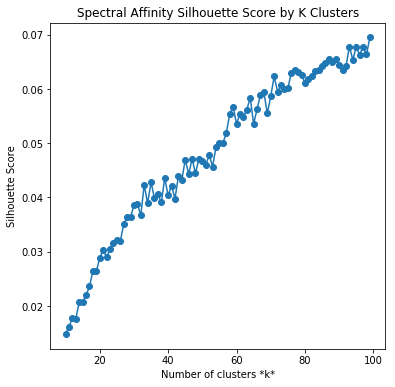

In [446]:
from sklearn.cluster import SpectralClustering

silhouette_vals = []
list_k = list(range(10, 100))

for k in list_k:
    sc = SpectralClustering(n_clusters=k, random_state = 50)
    cluster_labels = sc.fit_predict(train_tfidf_pca)
    sil_score = silhouette_score(train_tfidf_pca, cluster_labels)
    silhouette_vals.append(sil_score)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_vals, '-o')
plt.title('Spectral Affinity Silhouette Score by K Clusters')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Score')

The silhouette score for spectral affinity clustering increases as the number of clusters increases.

In [449]:
# Spectral Affinity; Looking into the cluster

n_clusters = 100#bible_pruned['author'].nunique()

spec = SpectralClustering(n_clusters = n_clusters, random_state = 30)
spec_train_clusts = spec.fit_predict(train_tfidf_pca)

# matching clusters to text their features
spec_train_clusters_df = train_set_PP.copy()
spec_train_clusters_df['cluster'] = spec_train_clusts

# Printing all clusters
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(spec_train_clusters_df[spec_train_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])

Cluster # 0


,book_chapter,author,testament
1039,Philemon 1,Paul,NT
1012,Philippians 3,Paul,NT
1011,Philippians 2,Paul,NT
1010,Philippians 1,Paul,NT
1004,Ephesians 1,Paul,NT
1013,Philippians 4,Paul,NT
1009,Ephesians 6,Paul,NT
1014,Colossians 1,Paul,NT
998,Galatians 1,Paul,NT
1016,Colossians 3,Paul,NT


Cluster # 1


,book_chapter,author,testament
932,Acts of the Apostles 8,Luke,NT
838,Matthew 3,Matthew,NT
926,Acts of the Apostles 2,Luke,NT
933,Acts of the Apostles 9,Luke,NT
936,Acts of the Apostles 12,Luke,NT
929,Acts of the Apostles 5,Luke,NT
927,Acts of the Apostles 3,Luke,NT
882,Luke 3,Luke,NT
925,Acts of the Apostles 1,Luke,NT
880,Luke 1,Luke,NT


Cluster # 2


,book_chapter,author,testament
473,Job 38,Job,OT
463,Job 28,Job,OT
447,Job 12,Job,OT
0,Genesis 1,Moses,OT
461,Job 26,Job,OT


Cluster # 3


,book_chapter,author,testament
937,Acts of the Apostles 13,Luke,NT
943,Acts of the Apostles 19,Luke,NT
952,Acts of the Apostles 28,Luke,NT
941,Acts of the Apostles 17,Luke,NT
939,Acts of the Apostles 15,Luke,NT
942,Acts of the Apostles 18,Luke,NT
938,Acts of the Apostles 14,Luke,NT
945,Acts of the Apostles 21,Luke,NT
944,Acts of the Apostles 20,Luke,NT
940,Acts of the Apostles 16,Luke,NT


Cluster # 4


,book_chapter,author,testament
1045,2 John 1,John,NT
909,John 6,John,NT
918,John 15,John,NT
917,John 14,John,NT
913,John 10,John,NT
1041,1 John 2,John,NT
920,John 17,John,NT
908,John 5,John,NT
911,John 8,John,NT
841,Matthew 6,Matthew,NT


Cluster # 5


,book_chapter,author,testament
590,Proverbs 15,Solomon,OT
601,Proverbs 26,Solomon,OT
591,Proverbs 16,Solomon,OT
595,Proverbs 20,Solomon,OT
602,Proverbs 27,Solomon,OT
592,Proverbs 17,Solomon,OT
614,Ecclesiastes 10,Solomon,OT
593,Proverbs 18,Solomon,OT
589,Proverbs 14,Solomon,OT


Cluster # 6


,book_chapter,author,testament
411,Ezra 9,Ezra,OT
704,Jeremiah 14,Jeremiah,OT
478,Psalms 2,David,OT
804,Daniel 9,Daniel,OT
650,Isaiah 26,Isaiah,OT
700,Jeremiah 10,Jeremiah,OT
549,Psalms 79,Asaph,OT
416,Nehemiah 4,Nehemiah,OT
559,Psalms 90,Moses,OT
688,Isaiah 64,Isaiah,OT


Cluster # 7


,book_chapter,author,testament
431,Esther 6,Mordecai,OT
432,Esther 7,Mordecai,OT
429,Esther 4,Mordecai,OT
433,Esther 8,Mordecai,OT
427,Esther 2,Mordecai,OT
428,Esther 3,Mordecai,OT
434,Esther 9,Mordecai,OT


Cluster # 8


,book_chapter,author,testament
513,Psalms 39,David,OT
522,Psalms 49,Sons of Korah,OT
525,Psalms 52,David,OT
534,Psalms 61,David,OT
557,Psalms 87,Sons of Korah,OT
499,Psalms 24,David,OT
480,Psalms 4,David,OT
485,Psalms 9,David,OT
552,Psalms 82,Asaph,OT
532,Psalms 59,David,OT


Cluster # 9


,book_chapter,author,testament
112,Leviticus 23,Moses,OT
145,Numbers 29,Moses,OT
91,Leviticus 2,Moses,OT
144,Numbers 28,Moses,OT
131,Numbers 15,Moses,OT


Cluster # 10


,book_chapter,author,testament
159,Deuteronomy 7,Moses,OT
167,Deuteronomy 15,Moses,OT
810,Hosea 3,Hosea,OT
71,Exodus 22,Moses,OT
70,Exodus 21,Moses,OT
751,Ezekiel 4,Ezekiel,OT
177,Deuteronomy 25,Moses,OT
174,Deuteronomy 22,Moses,OT
173,Deuteronomy 21,Moses,OT
114,Leviticus 25,Moses,OT


Cluster # 11


,book_chapter,author,testament
127,Numbers 11,Moses,OT
81,Exodus 32,Moses,OT
66,Exodus 17,Moses,OT
65,Exodus 16,Moses,OT
82,Exodus 33,Moses,OT
187,Joshua 1,Joshua,OT
73,Exodus 24,Moses,OT
68,Exodus 19,Moses,OT
67,Exodus 18,Moses,OT
83,Exodus 34,Moses,OT


Cluster # 12


,book_chapter,author,testament
283,2 Samuel 17,Samuel,OT
281,2 Samuel 15,Samuel,OT
280,2 Samuel 14,Samuel,OT
282,2 Samuel 16,Samuel,OT
279,2 Samuel 13,Samuel,OT


Cluster # 13


,book_chapter,author,testament
489,Psalms 14,David,OT
526,Psalms 53,David,OT


Cluster # 14


,book_chapter,author,testament
323,2 Kings 11,Jeremiah,OT
286,2 Samuel 20,Samuel,OT
390,2 Chronicles 24,Ezra,OT
291,1 Kings 1,Jeremiah,OT
293,1 Kings 3,Jeremiah,OT
292,1 Kings 2,Jeremiah,OT


Cluster # 15


,book_chapter,author,testament
308,1 Kings 18,Jeremiah,OT
314,2 Kings 2,Jeremiah,OT
307,1 Kings 17,Jeremiah,OT
313,2 Kings 1,Jeremiah,OT
309,1 Kings 19,Jeremiah,OT


Cluster # 16


,book_chapter,author,testament
357,1 Chronicles 20,Ezra,OT
48,Genesis 49,Moses,OT
318,2 Kings 6,Jeremiah,OT
316,2 Kings 4,Jeremiah,OT
737,Jeremiah 47,Jeremiah,OT
319,2 Kings 7,Jeremiah,OT
122,Numbers 6,Moses,OT
757,Ezekiel 10,Ezekiel,OT
435,Esther 10,Mordecai,OT
906,John 3,John,NT


Cluster # 17


,book_chapter,author,testament
30,Genesis 31,Moses,OT
28,Genesis 29,Moses,OT
29,Genesis 30,Moses,OT


Cluster # 18


,book_chapter,author,testament
87,Exodus 38,Moses,OT
76,Exodus 27,Moses,OT


Cluster # 19


,book_chapter,author,testament
218,Judges 8,Samuel,OT
217,Judges 7,Samuel,OT


Cluster # 20


,book_chapter,author,testament
639,Isaiah 15,Isaiah,OT
640,Isaiah 16,Isaiah,OT
738,Jeremiah 48,Jeremiah,OT


Cluster # 21


,book_chapter,author,testament
788,Ezekiel 41,Ezekiel,OT
296,1 Kings 6,Jeremiah,OT
369,2 Chronicles 3,Ezra,OT
787,Ezekiel 40,Ezekiel,OT


Cluster # 22


,book_chapter,author,testament
381,2 Chronicles 15,Ezra,OT
382,2 Chronicles 16,Ezra,OT
380,2 Chronicles 14,Ezra,OT


Cluster # 23


,book_chapter,author,testament
15,Genesis 16,Moses,OT
14,Genesis 15,Moses,OT
11,Genesis 12,Moses,OT
12,Genesis 13,Moses,OT


Cluster # 24


,book_chapter,author,testament
22,Genesis 23,Moses,OT
20,Genesis 21,Moses,OT
16,Genesis 17,Moses,OT
21,Genesis 22,Moses,OT


Cluster # 25


,book_chapter,author,testament
731,Jeremiah 41,Jeremiah,OT
730,Jeremiah 40,Jeremiah,OT


Cluster # 26


,book_chapter,author,testament
922,John 19,John,NT
907,John 4,John,NT
915,John 12,John,NT
910,John 7,John,NT
903,Luke 24,Luke,NT
905,John 2,John,NT
879,Mark 16,John Mark,NT
914,John 11,John,NT
863,Matthew 28,Matthew,NT
923,John 20,John,NT


Cluster # 27


,book_chapter,author,testament
226,Judges 16,Samuel,OT
225,Judges 15,Samuel,OT


Cluster # 28


,book_chapter,author,testament
302,1 Kings 12,Jeremiah,OT
378,2 Chronicles 12,Ezra,OT
304,1 Kings 14,Jeremiah,OT
376,2 Chronicles 10,Ezra,OT


Cluster # 29


,book_chapter,author,testament
384,2 Chronicles 18,Ezra,OT
312,1 Kings 22,Jeremiah,OT


Cluster # 30


,book_chapter,author,testament
96,Leviticus 7,Moses,OT
90,Leviticus 1,Moses,OT
93,Leviticus 4,Moses,OT
78,Exodus 29,Moses,OT
105,Leviticus 16,Moses,OT
95,Leviticus 6,Moses,OT
106,Leviticus 17,Moses,OT
92,Leviticus 3,Moses,OT


Cluster # 31


,book_chapter,author,testament
742,Jeremiah 52,Jeremiah,OT
729,Jeremiah 39,Jeremiah,OT
337,2 Kings 25,Jeremiah,OT


Cluster # 32


,book_chapter,author,testament
806,Daniel 11,Daniel,OT
736,Jeremiah 46,Jeremiah,OT
50,Exodus 1,Moses,OT
667,Isaiah 43,Isaiah,OT
518,Psalms 45,Sons of Korah,OT
685,Isaiah 61,Isaiah,OT
962,Romans 10,Paul,NT
684,Isaiah 60,Isaiah,OT
963,Romans 11,Paul,NT
821,Hosea 14,Hosea,OT


Cluster # 33


,book_chapter,author,testament
289,2 Samuel 23,Samuel,OT
348,1 Chronicles 11,Ezra,OT


Cluster # 34


,book_chapter,author,testament
696,Jeremiah 6,Jeremiah,OT
565,Psalms 122,David,OT
626,Isaiah 2,Isaiah,OT
830,Zechariah 9,Zechariah,OT
756,Ezekiel 9,Ezekiel,OT
387,2 Chronicles 21,Ezra,OT
649,Isaiah 25,Isaiah,OT
744,Lamentations 2,Jeremiah,OT
833,Zechariah 12,Zechariah,OT
746,Lamentations 4,Jeremiah,OT


Cluster # 35


,book_chapter,author,testament
256,1 Samuel 21,Samuel,OT
271,2 Samuel 5,Samuel,OT
277,2 Samuel 11,Samuel,OT
261,1 Samuel 26,Samuel,OT
355,1 Chronicles 18,Ezra,OT
252,1 Samuel 17,Samuel,OT
278,2 Samuel 12,Samuel,OT
274,2 Samuel 8,Samuel,OT
265,1 Samuel 30,Samuel,OT
260,1 Samuel 25,Samuel,OT


Cluster # 36


,book_chapter,author,testament
437,Job 2,Job,OT
477,Job 42,Job,OT
436,Job 1,Job,OT


Cluster # 37


,book_chapter,author,testament
610,Ecclesiastes 6,Solomon,OT
608,Ecclesiastes 4,Solomon,OT
606,Ecclesiastes 2,Solomon,OT
605,Ecclesiastes 1,Solomon,OT
612,Ecclesiastes 8,Solomon,OT


Cluster # 38


,book_chapter,author,testament
7,Genesis 8,Moses,OT
8,Genesis 9,Moses,OT
5,Genesis 6,Moses,OT


Cluster # 39


,book_chapter,author,testament
192,Joshua 6,Joshua,OT
191,Joshua 5,Joshua,OT
193,Joshua 7,Joshua,OT
194,Joshua 8,Joshua,OT
195,Joshua 9,Joshua,OT
212,Judges 2,Samuel,OT
210,Joshua 24,Joshua,OT
824,Zechariah 3,Zechariah,OT
190,Joshua 4,Joshua,OT
197,Joshua 11,Joshua,OT


Cluster # 40


,book_chapter,author,testament
869,Mark 6,John Mark,NT
849,Matthew 14,Matthew,NT


Cluster # 41


,book_chapter,author,testament
912,John 9,John,NT
749,Ezekiel 2,Ezekiel,OT
454,Job 19,Job,OT
452,Job 17,Job,OT
471,Job 36,Job,OT
446,Job 11,Job,OT
457,Job 22,Job,OT
467,Job 32,Job,OT
466,Job 31,Job,OT
750,Ezekiel 3,Ezekiel,OT


Cluster # 42


,book_chapter,author,testament
268,2 Samuel 2,Samuel,OT
269,2 Samuel 3,Samuel,OT


Cluster # 43


,book_chapter,author,testament
857,Matthew 22,Matthew,NT
899,Luke 20,Luke,NT
875,Mark 12,John Mark,NT


Cluster # 44


,book_chapter,author,testament
272,2 Samuel 6,Samuel,OT
371,2 Chronicles 5,Ezra,OT
353,1 Chronicles 16,Ezra,OT
352,1 Chronicles 15,Ezra,OT


Cluster # 45


,book_chapter,author,testament
2,Genesis 3,Moses,OT
1,Genesis 2,Moses,OT


Cluster # 46


,book_chapter,author,testament
235,Ruth 4,Samuel,OT
836,Matthew 1,Matthew,NT
233,Ruth 2,Samuel,OT
234,Ruth 3,Samuel,OT


Cluster # 47


,book_chapter,author,testament
660,Isaiah 36,Isaiah,OT
330,2 Kings 18,Jeremiah,OT
398,2 Chronicles 32,Ezra,OT
331,2 Kings 19,Jeremiah,OT
661,Isaiah 37,Isaiah,OT


Cluster # 48


,book_chapter,author,testament
800,Daniel 5,Daniel,OT
801,Daniel 6,Daniel,OT
796,Daniel 1,Daniel,OT
797,Daniel 2,Daniel,OT


Cluster # 49


,book_chapter,author,testament
299,1 Kings 9,Jeremiah,OT
374,2 Chronicles 8,Ezra,OT
300,1 Kings 10,Jeremiah,OT
301,1 Kings 11,Jeremiah,OT
295,1 Kings 5,Jeremiah,OT
373,2 Chronicles 7,Ezra,OT


Cluster # 50


,book_chapter,author,testament
242,1 Samuel 7,Samuel,OT
251,1 Samuel 16,Samuel,OT
263,1 Samuel 28,Samuel,OT
245,1 Samuel 10,Samuel,OT
243,1 Samuel 8,Samuel,OT
246,1 Samuel 11,Samuel,OT
247,1 Samuel 12,Samuel,OT
250,1 Samuel 15,Samuel,OT


Cluster # 51


,book_chapter,author,testament
663,Isaiah 39,Isaiah,OT
332,2 Kings 20,Jeremiah,OT


Cluster # 52


,book_chapter,author,testament
51,Exodus 2,Moses,OT
40,Genesis 41,Moses,OT
55,Exodus 6,Moses,OT
56,Exodus 7,Moses,OT
59,Exodus 10,Moses,OT
39,Genesis 40,Moses,OT


Cluster # 53


,book_chapter,author,testament
276,2 Samuel 10,Samuel,OT
356,1 Chronicles 19,Ezra,OT


Cluster # 54


,book_chapter,author,testament
493,Psalms 18,David,OT
288,2 Samuel 22,Samuel,OT


Cluster # 55


,book_chapter,author,testament
334,2 Kings 22,Jeremiah,OT
400,2 Chronicles 34,Ezra,OT


Cluster # 56


,book_chapter,author,testament
207,Joshua 21,Joshua,OT
343,1 Chronicles 6,Ezra,OT


Cluster # 57


,book_chapter,author,testament
578,Proverbs 3,Solomon,OT
577,Proverbs 2,Solomon,OT
580,Proverbs 5,Solomon,OT
583,Proverbs 8,Solomon,OT
584,Proverbs 9,Solomon,OT
576,Proverbs 1,Solomon,OT
579,Proverbs 4,Solomon,OT


Cluster # 58


,book_chapter,author,testament
321,2 Kings 9,Jeremiah,OT
388,2 Chronicles 22,Ezra,OT
322,2 Kings 10,Jeremiah,OT
320,2 Kings 8,Jeremiah,OT
311,1 Kings 21,Jeremiah,OT


Cluster # 59


,book_chapter,author,testament
924,John 21,John,NT
921,John 18,John,NT
861,Matthew 26,Matthew,NT
916,John 13,John,NT
877,Mark 14,John Mark,NT


Cluster # 60


,book_chapter,author,testament
27,Genesis 28,Moses,OT
32,Genesis 33,Moses,OT
31,Genesis 32,Moses,OT
338,1 Chronicles 1,Ezra,OT
35,Genesis 36,Moses,OT


Cluster # 61


,book_chapter,author,testament
775,Ezekiel 28,Ezekiel,OT
752,Ezekiel 5,Ezekiel,OT
781,Ezekiel 34,Ezekiel,OT
782,Ezekiel 35,Ezekiel,OT
768,Ezekiel 21,Ezekiel,OT
761,Ezekiel 14,Ezekiel,OT
754,Ezekiel 7,Ezekiel,OT
778,Ezekiel 31,Ezekiel,OT
786,Ezekiel 39,Ezekiel,OT
758,Ezekiel 11,Ezekiel,OT


Cluster # 62


,book_chapter,author,testament
41,Genesis 42,Moses,OT
36,Genesis 37,Moses,OT
42,Genesis 43,Moses,OT
49,Genesis 50,Moses,OT
44,Genesis 45,Moses,OT
47,Genesis 48,Moses,OT


Cluster # 63


,book_chapter,author,testament
273,2 Samuel 7,Samuel,OT
354,1 Chronicles 17,Ezra,OT


Cluster # 64


,book_chapter,author,testament
327,2 Kings 15,Jeremiah,OT
333,2 Kings 21,Jeremiah,OT
392,2 Chronicles 26,Ezra,OT
394,2 Chronicles 28,Ezra,OT
335,2 Kings 23,Jeremiah,OT
329,2 Kings 17,Jeremiah,OT
393,2 Chronicles 27,Ezra,OT
631,Isaiah 7,Isaiah,OT
391,2 Chronicles 25,Ezra,OT


Cluster # 65


,book_chapter,author,testament
403,Ezra 1,Ezra,OT
407,Ezra 5,Ezra,OT
406,Ezra 4,Ezra,OT
402,2 Chronicles 36,Ezra,OT


Cluster # 66


,book_chapter,author,testament
237,1 Samuel 2,Samuel,OT
239,1 Samuel 4,Samuel,OT
236,1 Samuel 1,Samuel,OT
238,1 Samuel 3,Samuel,OT


Cluster # 67


,book_chapter,author,testament
200,Joshua 14,Joshua,OT
150,Numbers 34,Moses,OT
129,Numbers 13,Moses,OT
152,Numbers 36,Moses,OT


Cluster # 68


,book_chapter,author,testament
64,Exodus 15,Moses,OT
491,Psalms 16,David,OT
558,Psalms 88,Sons of Korah,OT
505,Psalms 30,David,OT
543,Psalms 73,Asaph,OT
538,Psalms 65,David,OT
496,Psalms 21,David,OT
533,Psalms 60,David,OT
517,Psalms 44,Sons of Korah,OT
506,Psalms 31,David,OT


Cluster # 69


,book_chapter,author,testament
981,1 Corinthians 13,Paul,NT
618,Song of Solomon 2,Solomon,OT
1046,3 John 1,John,NT
620,Song of Solomon 4,Solomon,OT
624,Song of Solomon 8,Solomon,OT
617,Song of Solomon 1,Solomon,OT
622,Song of Solomon 6,Solomon,OT


Cluster # 70


,book_chapter,author,testament
703,Jeremiah 13,Jeremiah,OT
739,Jeremiah 49,Jeremiah,OT
706,Jeremiah 16,Jeremiah,OT
699,Jeremiah 9,Jeremiah,OT
697,Jeremiah 7,Jeremiah,OT
829,Zechariah 8,Zechariah,OT
725,Jeremiah 35,Jeremiah,OT
715,Jeremiah 25,Jeremiah,OT
701,Jeremiah 11,Jeremiah,OT
709,Jeremiah 19,Jeremiah,OT


Cluster # 71


,book_chapter,author,testament
596,Proverbs 21,Solomon,OT
603,Proverbs 28,Solomon,OT
511,Psalms 37,David,OT
586,Proverbs 11,Solomon,OT
587,Proverbs 12,Solomon,OT
588,Proverbs 13,Solomon,OT
599,Proverbs 24,Solomon,OT
486,Psalms 11,David,OT
604,Proverbs 29,Solomon,OT


Cluster # 72


,book_chapter,author,testament
988,2 Corinthians 4,Paul,NT
984,1 Corinthians 16,Paul,NT
1019,1 Thessalonians 2,Paul,NT
732,Jeremiah 42,Jeremiah,OT
979,1 Corinthians 11,Paul,NT
985,2 Corinthians 1,Paul,NT
995,2 Corinthians 11,Paul,NT
1022,1 Thessalonians 5,Paul,NT
994,2 Corinthians 10,Paul,NT
1044,1 John 5,John,NT


Cluster # 73


,book_chapter,author,testament
1055,Revelation 9,John,NT
1054,Revelation 8,John,NT
1067,Revelation 21,John,NT
1060,Revelation 14,John,NT
1063,Revelation 17,John,NT
1051,Revelation 5,John,NT
1050,Revelation 4,John,NT
1065,Revelation 19,John,NT
1061,Revelation 15,John,NT
1058,Revelation 12,John,NT


Cluster # 74


,book_chapter,author,testament
249,1 Samuel 14,Samuel,OT
248,1 Samuel 13,Samuel,OT
258,1 Samuel 23,Samuel,OT
254,1 Samuel 19,Samuel,OT
275,2 Samuel 9,Samuel,OT
267,2 Samuel 1,Samuel,OT
266,1 Samuel 31,Samuel,OT
255,1 Samuel 20,Samuel,OT
287,2 Samuel 21,Samuel,OT


Cluster # 75


,book_chapter,author,testament
142,Numbers 26,Moses,OT
120,Numbers 4,Moses,OT
119,Numbers 3,Moses,OT


Cluster # 76


,book_chapter,author,testament
166,Deuteronomy 14,Moses,OT
135,Numbers 19,Moses,OT
104,Leviticus 15,Moses,OT
100,Leviticus 11,Moses,OT


Cluster # 77


,book_chapter,author,testament
362,1 Chronicles 25,Ezra,OT
361,1 Chronicles 24,Ezra,OT
340,1 Chronicles 3,Ezra,OT
10,Genesis 11,Moses,OT
364,1 Chronicles 27,Ezra,OT
342,1 Chronicles 5,Ezra,OT
410,Ezra 8,Ezra,OT
363,1 Chronicles 26,Ezra,OT
341,1 Chronicles 4,Ezra,OT
45,Genesis 46,Moses,OT


Cluster # 78


,book_chapter,author,testament
867,Mark 4,John Mark,NT
843,Matthew 8,Matthew,NT
885,Luke 6,Luke,NT
842,Matthew 7,Matthew,NT
866,Mark 3,John Mark,NT
892,Luke 13,Luke,NT
850,Matthew 15,Matthew,NT
884,Luke 5,Luke,NT
847,Matthew 12,Matthew,NT
844,Matthew 9,Matthew,NT


Cluster # 79


,book_chapter,author,testament
1027,1 Timothy 2,Paul,NT
953,Romans 1,Paul,NT
1031,1 Timothy 6,Paul,NT
1032,2 Timothy 1,Paul,NT
1035,2 Timothy 4,Paul,NT
1034,2 Timothy 3,Paul,NT
1028,1 Timothy 3,Paul,NT
1033,2 Timothy 2,Paul,NT
1038,Titus 3,Paul,NT
1036,Titus 1,Paul,NT


Cluster # 80


,book_chapter,author,testament
740,Jeremiah 50,Jeremiah,OT
717,Jeremiah 27,Jeremiah,OT
719,Jeremiah 29,Jeremiah,OT
741,Jeremiah 51,Jeremiah,OT


Cluster # 81


,book_chapter,author,testament
854,Matthew 19,Matthew,NT
872,Mark 9,John Mark,NT
855,Matthew 20,Matthew,NT
873,Mark 10,John Mark,NT
888,Luke 9,Luke,NT


Cluster # 82


,book_chapter,author,testament
199,Joshua 13,Joshua,OT
221,Judges 11,Samuel,OT
155,Deuteronomy 3,Moses,OT
154,Deuteronomy 2,Moses,OT
198,Joshua 12,Joshua,OT
208,Joshua 22,Joshua,OT


Cluster # 83


,book_chapter,author,testament
147,Numbers 31,Moses,OT
365,1 Chronicles 28,Ezra,OT
359,1 Chronicles 22,Ezra,OT
368,2 Chronicles 2,Ezra,OT
383,2 Chronicles 17,Ezra,OT
349,1 Chronicles 12,Ezra,OT
366,1 Chronicles 29,Ezra,OT


Cluster # 84


,book_chapter,author,testament
728,Jeremiah 38,Jeremiah,OT
733,Jeremiah 43,Jeremiah,OT
716,Jeremiah 26,Jeremiah,OT
724,Jeremiah 34,Jeremiah,OT
735,Jeremiah 45,Jeremiah,OT
727,Jeremiah 37,Jeremiah,OT
711,Jeremiah 21,Jeremiah,OT
726,Jeremiah 36,Jeremiah,OT
710,Jeremiah 20,Jeremiah,OT


Cluster # 85


,book_chapter,author,testament
423,Nehemiah 11,Nehemiah,OT
422,Nehemiah 10,Nehemiah,OT
346,1 Chronicles 9,Ezra,OT
425,Nehemiah 13,Nehemiah,OT
401,2 Chronicles 35,Ezra,OT
424,Nehemiah 12,Nehemiah,OT
124,Numbers 8,Moses,OT
405,Ezra 3,Ezra,OT
415,Nehemiah 3,Nehemiah,OT


Cluster # 86


,book_chapter,author,testament
1007,Ephesians 4,Paul,NT
974,1 Corinthians 6,Paul,NT
960,Romans 8,Paul,NT
1015,Colossians 2,Paul,NT
1005,Ephesians 2,Paul,NT
980,1 Corinthians 12,Paul,NT
958,Romans 6,Paul,NT
1002,Galatians 5,Paul,NT


Cluster # 87


,book_chapter,author,testament
132,Numbers 16,Moses,OT
133,Numbers 17,Moses,OT
136,Numbers 20,Moses,OT
143,Numbers 27,Moses,OT
130,Numbers 14,Moses,OT


Cluster # 88


,book_chapter,author,testament
959,Romans 7,Paul,NT
956,Romans 4,Paul,NT
1000,Galatians 3,Paul,NT
954,Romans 2,Paul,NT
977,1 Corinthians 9,Paul,NT


Cluster # 89


,book_chapter,author,testament
88,Exodus 39,Moses,OT
77,Exodus 28,Moses,OT


Cluster # 90


,book_chapter,author,testament
202,Joshua 16,Joshua,OT
794,Ezekiel 47,Ezekiel,OT
203,Joshua 17,Joshua,OT
201,Joshua 15,Joshua,OT
211,Judges 1,Samuel,OT


Cluster # 91


,book_chapter,author,testament
1048,Revelation 2,John,NT
1049,Revelation 3,John,NT


Cluster # 92


,book_chapter,author,testament
151,Numbers 35,Moses,OT
206,Joshua 20,Joshua,OT


Cluster # 93


,book_chapter,author,testament
948,Acts of the Apostles 24,Luke,NT
947,Acts of the Apostles 23,Luke,NT
950,Acts of the Apostles 26,Luke,NT
946,Acts of the Apostles 22,Luke,NT
949,Acts of the Apostles 25,Luke,NT


Cluster # 94


,book_chapter,author,testament
103,Leviticus 14,Moses,OT
102,Leviticus 13,Moses,OT
121,Numbers 5,Moses,OT


Cluster # 95


,book_chapter,author,testament
117,Numbers 1,Moses,OT
118,Numbers 2,Moses,OT
126,Numbers 10,Moses,OT


Cluster # 96


,book_chapter,author,testament
372,2 Chronicles 6,Ezra,OT
298,1 Kings 8,Jeremiah,OT


Cluster # 97


,book_chapter,author,testament
80,Exodus 31,Moses,OT
84,Exodus 35,Moses,OT


Cluster # 98


,book_chapter,author,testament
158,Deuteronomy 6,Moses,OT
209,Joshua 23,Joshua,OT
115,Leviticus 26,Moses,OT
162,Deuteronomy 10,Moses,OT
178,Deuteronomy 26,Moses,OT
181,Deuteronomy 29,Moses,OT
160,Deuteronomy 8,Moses,OT
156,Deuteronomy 4,Moses,OT
161,Deuteronomy 9,Moses,OT
182,Deuteronomy 30,Moses,OT


Cluster # 99


,book_chapter,author,testament
483,Psalms 7,David,OT
553,Psalms 83,Asaph,OT
500,Psalms 25,David,OT
563,Psalms 109,David,OT
571,Psalms 141,David,OT
528,Psalms 55,David,OT
508,Psalms 34,David,OT
567,Psalms 131,David,OT
510,Psalms 36,David,OT
515,Psalms 41,David,OT


In [450]:
n_clusters = 100 #bible_pruned['author'].nunique()

spec = SpectralClustering(n_clusters = n_clusters, random_state = 30)
spec_test_clusts = spec.fit_predict(test_tfidf_pca)

# matching clusters to text their features
spec_test_clusters_df = test_set_PP.copy()
spec_test_clusters_df['cluster'] = spec_test_clusts

# Printing all clusters
for cluster in range(n_clusters):
    print('Cluster #', cluster)
    display(spec_test_clusters_df[spec_test_clusters_df['cluster'] == cluster][['book_chapter','author','testament']])
    

Cluster # 0


,book_chapter,author,testament
146,Numbers 30,Moses,OT
975,1 Corinthians 7,Paul,NT


Cluster # 1


,book_chapter,author,testament
712,Jeremiah 22,Jeremiah,OT
691,Jeremiah 1,Jeremiah,OT


Cluster # 2


,book_chapter,author,testament
540,Psalms 69,David,OT
509,Psalms 35,David,OT
514,Psalms 40,David,OT
541,Psalms 70,David,OT


Cluster # 3


,book_chapter,author,testament
54,Exodus 5,Moses,OT
53,Exodus 4,Moses,OT
60,Exodus 11,Moses,OT
58,Exodus 9,Moses,OT
57,Exodus 8,Moses,OT
63,Exodus 14,Moses,OT


Cluster # 4


,book_chapter,author,testament
396,2 Chronicles 30,Ezra,OT
395,2 Chronicles 29,Ezra,OT
397,2 Chronicles 31,Ezra,OT


Cluster # 5


,book_chapter,author,testament
671,Isaiah 47,Isaiah,OT
598,Proverbs 23,Solomon,OT


Cluster # 6


,book_chapter,author,testament
414,Nehemiah 2,Nehemiah,OT
418,Nehemiah 6,Nehemiah,OT
426,Esther 1,Mordecai,OT


Cluster # 7


,book_chapter,author,testament
113,Leviticus 24,Moses,OT
679,Isaiah 55,Isaiah,OT
23,Genesis 24,Moses,OT
641,Isaiah 17,Isaiah,OT
531,Psalms 58,David,OT
702,Jeremiah 12,Jeremiah,OT
498,Psalms 23,David,OT
141,Numbers 25,Moses,OT
171,Deuteronomy 19,Moses,OT
3,Genesis 4,Moses,OT


Cluster # 8


,book_chapter,author,testament
642,Isaiah 18,Isaiah,OT
664,Isaiah 40,Isaiah,OT
825,Zechariah 4,Zechariah,OT


Cluster # 9


,book_chapter,author,testament
792,Ezekiel 45,Ezekiel,OT
123,Numbers 7,Moses,OT
94,Leviticus 5,Moses,OT
793,Ezekiel 46,Ezekiel,OT


Cluster # 10


,book_chapter,author,testament
25,Genesis 26,Moses,OT
17,Genesis 18,Moses,OT
19,Genesis 20,Moses,OT


Cluster # 11


,book_chapter,author,testament
902,Luke 23,Luke,NT
878,Mark 15,John Mark,NT
862,Matthew 27,Matthew,NT


Cluster # 12


,book_chapter,author,testament
358,1 Chronicles 21,Ezra,OT


Cluster # 13


,book_chapter,author,testament
585,Proverbs 10,Solomon,OT
594,Proverbs 19,Solomon,OT
597,Proverbs 22,Solomon,OT


Cluster # 14


,book_chapter,author,testament
99,Leviticus 10,Moses,OT
128,Numbers 12,Moses,OT
97,Leviticus 8,Moses,OT
98,Leviticus 9,Moses,OT


Cluster # 15


,book_chapter,author,testament
367,2 Chronicles 1,Ezra,OT
294,1 Kings 4,Jeremiah,OT
375,2 Chronicles 9,Ezra,OT


Cluster # 16


,book_chapter,author,testament
389,2 Chronicles 23,Ezra,OT
324,2 Kings 12,Jeremiah,OT


Cluster # 17


,book_chapter,author,testament
317,2 Kings 5,Jeremiah,OT
325,2 Kings 13,Jeremiah,OT
326,2 Kings 14,Jeremiah,OT


Cluster # 18


,book_chapter,author,testament
1043,1 John 4,John,NT
1042,1 John 3,John,NT


Cluster # 19


,book_chapter,author,testament
6,Genesis 7,Moses,OT


Cluster # 20


,book_chapter,author,testament
996,2 Corinthians 12,Paul,NT
972,1 Corinthians 4,Paul,NT
1017,Colossians 4,Paul,NT
992,2 Corinthians 8,Paul,NT


Cluster # 21


,book_chapter,author,testament
484,Psalms 8,David,OT
523,Psalms 50,Asaph,OT
544,Psalms 74,Asaph,OT
449,Job 14,Job,OT
442,Job 7,Job,OT
492,Psalms 17,David,OT
1068,Revelation 22,John,NT
813,Hosea 6,Hosea,OT
582,Proverbs 7,Solomon,OT
681,Isaiah 57,Isaiah,OT


Cluster # 22


,book_chapter,author,testament
306,1 Kings 16,Jeremiah,OT
305,1 Kings 15,Jeremiah,OT


Cluster # 23


,book_chapter,author,testament
379,2 Chronicles 13,Ezra,OT
377,2 Chronicles 11,Ezra,OT


Cluster # 24


,book_chapter,author,testament
883,Luke 4,Luke,NT
839,Matthew 4,Matthew,NT


Cluster # 25


,book_chapter,author,testament
789,Ezekiel 42,Ezekiel,OT
297,1 Kings 7,Jeremiah,OT


Cluster # 26


,book_chapter,author,testament
216,Judges 6,Samuel,OT


Cluster # 27


,book_chapter,author,testament
75,Exodus 26,Moses,OT


Cluster # 28


,book_chapter,author,testament
196,Joshua 10,Joshua,OT


Cluster # 29


,book_chapter,author,testament
351,1 Chronicles 14,Ezra,OT
262,1 Samuel 27,Samuel,OT


Cluster # 30


,book_chapter,author,testament
643,Isaiah 19,Isaiah,OT
776,Ezekiel 29,Ezekiel,OT
777,Ezekiel 30,Ezekiel,OT
773,Ezekiel 26,Ezekiel,OT


Cluster # 31


,book_chapter,author,testament
46,Genesis 47,Moses,OT
38,Genesis 39,Moses,OT


Cluster # 32


,book_chapter,author,testament
13,Genesis 14,Moses,OT


Cluster # 33


,book_chapter,author,testament
966,Romans 14,Paul,NT
1020,1 Thessalonians 3,Paul,NT
462,Job 27,Job,OT
1018,1 Thessalonians 1,Paul,NT
674,Isaiah 50,Isaiah,OT
1021,1 Thessalonians 4,Paul,NT
1023,2 Thessalonians 1,Paul,NT
1024,2 Thessalonians 2,Paul,NT
896,Luke 17,Luke,NT


Cluster # 34


,book_chapter,author,testament
748,Ezekiel 1,Ezekiel,OT


Cluster # 35


,book_chapter,author,testament
430,Esther 5,Mordecai,OT


Cluster # 36


,book_chapter,author,testament
682,Isaiah 58,Isaiah,OT
686,Isaiah 62,Isaiah,OT
669,Isaiah 45,Isaiah,OT


Cluster # 37


,book_chapter,author,testament
339,1 Chronicles 2,Ezra,OT
9,Genesis 10,Moses,OT
4,Genesis 5,Moses,OT


Cluster # 38


,book_chapter,author,testament
74,Exodus 25,Moses,OT


Cluster # 39


,book_chapter,author,testament
871,Mark 8,John Mark,NT
870,Mark 7,John Mark,NT


Cluster # 40


,book_chapter,author,testament
222,Judges 12,Samuel,OT
220,Judges 10,Samuel,OT


Cluster # 41


,book_chapter,author,testament
224,Judges 14,Samuel,OT


Cluster # 42


,book_chapter,author,testament
205,Joshua 19,Joshua,OT
204,Joshua 18,Joshua,OT


Cluster # 43


,book_chapter,author,testament
153,Deuteronomy 1,Moses,OT
163,Deuteronomy 11,Moses,OT


Cluster # 44


,book_chapter,author,testament
783,Ezekiel 36,Ezekiel,OT
760,Ezekiel 13,Ezekiel,OT
769,Ezekiel 22,Ezekiel,OT


Cluster # 45


,book_chapter,author,testament
802,Daniel 7,Daniel,OT
799,Daniel 4,Daniel,OT


Cluster # 46


,book_chapter,author,testament
934,Acts of the Apostles 10,Luke,NT
935,Acts of the Apostles 11,Luke,NT


Cluster # 47


,book_chapter,author,testament
34,Genesis 35,Moses,OT
24,Genesis 25,Moses,OT
26,Genesis 27,Moses,OT


Cluster # 48


,book_chapter,author,testament
140,Numbers 24,Moses,OT
138,Numbers 22,Moses,OT


Cluster # 49


,book_chapter,author,testament
718,Jeremiah 28,Jeremiah,OT
336,2 Kings 24,Jeremiah,OT


Cluster # 50


,book_chapter,author,testament
886,Luke 7,Luke,NT


Cluster # 51


,book_chapter,author,testament
858,Matthew 23,Matthew,NT
890,Luke 11,Luke,NT


Cluster # 52


,book_chapter,author,testament
868,Mark 5,John Mark,NT
848,Matthew 13,Matthew,NT
887,Luke 8,Luke,NT


Cluster # 53


,book_chapter,author,testament
189,Joshua 3,Joshua,OT


Cluster # 54


,book_chapter,author,testament
562,Psalms 108,David,OT
530,Psalms 57,David,OT
568,Psalms 138,David,OT


Cluster # 55


,book_chapter,author,testament
168,Deuteronomy 16,Moses,OT
172,Deuteronomy 20,Moses,OT
108,Leviticus 19,Moses,OT
164,Deuteronomy 12,Moses,OT


Cluster # 56


,book_chapter,author,testament
419,Nehemiah 7,Nehemiah,OT


Cluster # 57


,book_chapter,author,testament
901,Luke 22,Luke,NT
874,Mark 11,John Mark,NT
898,Luke 19,Luke,NT
856,Matthew 21,Matthew,NT


Cluster # 58


,book_chapter,author,testament
795,Ezekiel 48,Ezekiel,OT


Cluster # 59


,book_chapter,author,testament
399,2 Chronicles 33,Ezra,OT


Cluster # 60


,book_chapter,author,testament
852,Matthew 17,Matthew,NT
897,Luke 18,Luke,NT


Cluster # 61


,book_chapter,author,testament
385,2 Chronicles 19,Ezra,OT
409,Ezra 7,Ezra,OT
408,Ezra 6,Ezra,OT


Cluster # 62


,book_chapter,author,testament
805,Daniel 10,Daniel,OT


Cluster # 63


,book_chapter,author,testament
350,1 Chronicles 13,Ezra,OT


Cluster # 64


,book_chapter,author,testament
232,Ruth 1,Samuel,OT


Cluster # 65


,book_chapter,author,testament
820,Hosea 13,Hosea,OT
635,Isaiah 11,Isaiah,OT
812,Hosea 5,Hosea,OT
818,Hosea 11,Hosea,OT
815,Hosea 8,Hosea,OT


Cluster # 66


,book_chapter,author,testament
503,Psalms 28,David,OT


Cluster # 67


,book_chapter,author,testament
876,Mark 13,John Mark,NT


Cluster # 68


,book_chapter,author,testament
951,Acts of the Apostles 27,Luke,NT


Cluster # 69


,book_chapter,author,testament
125,Numbers 9,Moses,OT


Cluster # 70


,book_chapter,author,testament
662,Isaiah 38,Isaiah,OT


Cluster # 71


,book_chapter,author,testament
328,2 Kings 16,Jeremiah,OT


Cluster # 72


,book_chapter,author,testament
285,2 Samuel 19,Samuel,OT
284,2 Samuel 18,Samuel,OT


Cluster # 73


,book_chapter,author,testament
955,Romans 3,Paul,NT
999,Galatians 2,Paul,NT


Cluster # 74


,book_chapter,author,testament
228,Judges 18,Samuel,OT


Cluster # 75


,book_chapter,author,testament
109,Leviticus 20,Moses,OT


Cluster # 76


,book_chapter,author,testament
613,Ecclesiastes 9,Solomon,OT
609,Ecclesiastes 5,Solomon,OT
611,Ecclesiastes 7,Solomon,OT


Cluster # 77


,book_chapter,author,testament
621,Song of Solomon 5,Solomon,OT
623,Song of Solomon 7,Solomon,OT


Cluster # 78


,book_chapter,author,testament
472,Job 37,Job,OT
170,Deuteronomy 18,Moses,OT
487,Psalms 12,David,OT
551,Psalms 81,Asaph,OT
507,Psalms 32,David,OT
547,Psalms 77,Asaph,OT
570,Psalms 140,David,OT


Cluster # 79


,book_chapter,author,testament
186,Deuteronomy 34,Joshua,OT
137,Numbers 21,Moses,OT
148,Numbers 32,Moses,OT


Cluster # 80


,book_chapter,author,testament
1066,Revelation 20,John,NT
1062,Revelation 16,John,NT
1057,Revelation 11,John,NT


Cluster # 81


,book_chapter,author,testament
723,Jeremiah 33,Jeremiah,OT
713,Jeremiah 23,Jeremiah,OT
668,Isaiah 44,Isaiah,OT
705,Jeremiah 15,Jeremiah,OT
720,Jeremiah 30,Jeremiah,OT


Cluster # 82


,book_chapter,author,testament
722,Jeremiah 32,Jeremiah,OT
734,Jeremiah 44,Jeremiah,OT


Cluster # 83


,book_chapter,author,testament
556,Psalms 86,David,OT
482,Psalms 6,David,OT


Cluster # 84


,book_chapter,author,testament
179,Deuteronomy 27,Moses,OT
185,Deuteronomy 33,Moses,OT


Cluster # 85


,book_chapter,author,testament
891,Luke 12,Luke,NT
845,Matthew 10,Matthew,NT
853,Matthew 18,Matthew,NT
889,Luke 10,Luke,NT


Cluster # 86


,book_chapter,author,testament
1037,Titus 2,Paul,NT
964,Romans 12,Paul,NT
1026,1 Timothy 1,Paul,NT


Cluster # 87


,book_chapter,author,testament
765,Ezekiel 18,Ezekiel,OT
791,Ezekiel 44,Ezekiel,OT
755,Ezekiel 8,Ezekiel,OT
134,Numbers 18,Moses,OT
110,Leviticus 21,Moses,OT


Cluster # 88


,book_chapter,author,testament
1059,Revelation 13,John,NT


Cluster # 89


,book_chapter,author,testament
1047,Revelation 1,John,NT


Cluster # 90


,book_chapter,author,testament
881,Luke 2,Luke,NT


Cluster # 91


,book_chapter,author,testament
420,Nehemiah 8,Nehemiah,OT


Cluster # 92


,book_chapter,author,testament
770,Ezekiel 23,Ezekiel,OT
693,Jeremiah 3,Jeremiah,OT


Cluster # 93


,book_chapter,author,testament
865,Mark 2,John Mark,NT


Cluster # 94


,book_chapter,author,testament
627,Isaiah 3,Isaiah,OT
652,Isaiah 28,Isaiah,OT
828,Zechariah 7,Zechariah,OT
747,Lamentations 5,Jeremiah,OT
656,Isaiah 32,Isaiah,OT


Cluster # 95


,book_chapter,author,testament
1003,Galatians 6,Paul,NT
1001,Galatians 4,Paul,NT
600,Proverbs 25,Solomon,OT
971,1 Corinthians 3,Paul,NT
987,2 Corinthians 3,Paul,NT
970,1 Corinthians 2,Paul,NT


Cluster # 96


,book_chapter,author,testament
957,Romans 5,Paul,NT
677,Isaiah 53,Isaiah,OT
983,1 Corinthians 15,Paul,NT


Cluster # 97


,book_chapter,author,testament
344,1 Chronicles 7,Ezra,OT
360,1 Chronicles 23,Ezra,OT
412,Ezra 10,Ezra,OT


Cluster # 98


,book_chapter,author,testament
244,1 Samuel 9,Samuel,OT
253,1 Samuel 18,Samuel,OT
347,1 Chronicles 10,Ezra,OT
259,1 Samuel 24,Samuel,OT


Cluster # 99


,book_chapter,author,testament
43,Genesis 44,Moses,OT


Experimenting with increasing the number of clusters for spectral affinity to k=100 above, the clusters in the train set group the same authors together very well, even across different books that the same authors wrote.

--- Clustering Conclusions ---

The overall clustering in euclidean space was bad enough that Mean Shift clustering couldn't make out more than one cluster among the entire training set.

However, looking into the clusters for both BOW and TF-IDF vectorizations demonstrated failry great clustering of authors even among the different books that each author contributed to; and the models proved to cluster the test sets very similar although with a little more noise (as expected).

Analytically, the BOW vectorization lead to smaller Sum of Squared Errors and larger Silhouette Scores than TF-IDF vectorization. These metrics both indicate that BOW produced more geometrically defined clusters.

Even in the supervised model to predict the testament to which a book chapter belonged produced a higher accuracy using BOW vectorizatiion versus TF-IDF vectorization. However, it's important to note that the SSE for the BOW features is smaller probably due to the smaller sample size; unfortunately space cannot handle more than 1 million characters at a time, so the training set had to be significantly reduced. (Also, BOW vectors take a lot of computing power to process).

Thus far BOW seems to be winning out as a clustering method. A few more experiments are graphs the test_set scores for the BOW vectors and increases clusters beyond the 22 cluster limit that I've been honoring. Although I have kept the clusters at the number of authors for each of teh clustering methods, it seems that the more clusters there are, the better they'll predict the author as was seen looking into the cluster empirically and also through the increase of the silhouette score as the number of clusters increases.

# Supervised Classification using Unsupervised Generated Features
Predicting the authors of the bible book_chapters.
---
Questions:
- Can unsupervised generated cluster assignments be used as a feature in a supervised learning classifier?
- What other unsupervised methods are there to extract features besides PCA and LSA? 

Game Plan:
Take the processed BOB (BOW) features and perform LSA on the features. Try classifying the text with and without normalizing the LSA results.

Then take the processed TF-IDF features, this time use truncated LSA and perform classification both with and with using normalized samples.

Classification methods to use include random forest, logistic regression, or other linear regression models, gradient boosting.

----

Also experiment with how well PCA creates clusters vs. LSA. Always normalize LSA components results.

Does PCA need to be normalized after?

I'm confused because PCA is normalized before transformation, while LSA uses normalization after. What's the deal? Why don't we normalize before using LSA? -- the internet seems to say that while there are definitely differences between PCA and LSA, it's up to the scientist to experiement with which methods work best.

What other unsupervised feature extraction methods can be used?

We aren't going to use the clusters as features; we'll just let those clusters be relatively purposeless. So it's okay.

Variables:
- BOW vs. TFIDF
- Either normalization before PCA, or normalization after PSA
- Supervised Learning Model

### 1. BOW Features Author Classification

In [454]:
# Variables for recal reference:
# train_set      =>
# test_set       =>
# train_set_PP
# test_set_PP
# train_set_bob
# test_set_bob
# train_set_tfidf
# train_set_tfidf

### --- 1a. PCA Features

In [459]:
train_bob_norm = normalize(train_set_bob)
test_bob_norm = normalize(test_set_bob)

pca = PCA(100)
pca.fit(train_bob_norm)
train_bob_pca = pca.transform(train_bob_norm)
test_bob_pca = pca.transform(test_bob_norm)

X_train = train_bob_pca
Y_train = train_set['author']
X_test = test_bob_pca
Y_test = test_set['author']

In [497]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 500)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)
print(clf.score(X_test,Y_test))
#confusion_matrix(Y_test,Y_predict)

0.4719626168224299


In [502]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 250)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.29439252336448596

In [510]:
# Support Vector Machines
from sklearn.svm import SVC

clf = SVC(degree = 3)
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.20093457943925233

### --- 1b. LSA Features

In [513]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
train_bob_svd = svd.fit_transform(train_set_bob)
test_bob_svd = svd.transform(test_set_bob)

train_bob_lsa = normalize(train_bob_svd)
test_bob_lsa = normalize(test_bob_svd)

X_train = train_bob_lsa
Y_train = train_set['author']
X_test = test_bob_lsa
Y_test = test_set['author']

svd.explained_variance_ratio_.sum()

0.9556085084453727

In [530]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 50)
clf.fit(X_train, Y_train)
print(clf.score(X_test,Y_test))

0.5093457943925234


In [531]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 250)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.3177570093457944

In [532]:
# Support Vector Machines
from sklearn.svm import SVC

clf = SVC(degree = 3)
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.20093457943925233

### --- 1c. LDA Features 

In [576]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 100)
train_bob_lda = lda.fit_transform(train_set_bob)
test_bob_lda = lda.transform(test_set_bob)

X_train = train_bob_lda
Y_train = train_set['author']
X_test = test_bob_lda
Y_test = test_set['author']

In [573]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 100)
clf.fit(X_train, Y_train)
print(clf.score(X_test,Y_test))

0.4158878504672897


In [578]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.4439252336448598

### --- 1d. NMF Features

In [579]:
from sklearn.decomposition import NMF

nmf = NMF(n_components = 100)
train_bob_nmf = nmf.fit_transform(train_set_bob)
test_bob_nmf = nmf.transform(test_set_bob)

X_train = train_bob_nmf
Y_train = train_set['author']
X_test = test_bob_nmf
Y_test = test_set['author']

In [584]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 500)
clf.fit(X_train, Y_train)
print(clf.score(X_test,Y_test))

0.411214953271028


In [581]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.3598130841121495

## 2. TF-IDF Feature Classification

### --- 2a. PCA Feature Extraction

In [586]:
train_tfidf_norm = normalize(train_set_tfidf)
test_tfidf_norm = normalize(test_set_tfidf)

pca = PCA(100)
pca.fit(train_tfidf_norm.todense())
train_tfidf_pca = pca.transform(train_tfidf_norm.todense())
test_tfidf_pca = pca.transform(test_tfidf_norm.todense())

X_train = train_tfidf_pca
Y_train = train_set_PP['author']
X_test = test_tfidf_pca
Y_test = test_set_PP['author']

In [590]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 100)
clf.fit(X_train, Y_train)
print(clf.score(X_test,Y_test))

0.7388059701492538


In [591]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.5373134328358209

### --- 2b. LSA Feature Extraction

In [592]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
train_tfidf_svd = svd.fit_transform(train_set_tfidf)
test_tfidf_svd = svd.transform(test_set_tfidf)

train_tfidf_lsa = normalize(train_tfidf_svd)
test_tfidf_lsa = normalize(test_tfidf_svd)

X_train = train_tfidf_lsa
Y_train = train_set_PP['author']
X_test = test_tfidf_lsa
Y_test = test_set_PP['author']

svd.explained_variance_ratio_.sum()

0.38792325481035356

In [597]:
#RandomForestClassifier
clf = RandomForestClassifier(max_depth = 20, n_estimators = 500)
clf.fit(X_train, Y_train)
print(clf.score(X_test,Y_test))

0.7611940298507462


In [599]:
#GradientBoostingClassifier
clf = GradientBoostingClassifier(max_depth=20, n_estimators = 500)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.6156716417910447

### --- 2c. LDA Feature Extraction

In [602]:
lda = LatentDirichletAllocation(n_components = 100)
train_tfidf_lda = lda.fit_transform(train_set_tfidf)
test_tfidf_lda = lda.transform(test_set_tfidf)

X_train = train_tfidf_lda
Y_train = train_set_PP['author']
X_test = test_tfidf_lda
Y_test = test_set_PP['author']

In [604]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 50)
clf.fit(X_train, Y_train)
clf.score(X_test,Y_test)

0.5708955223880597

In [605]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 50)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.44029850746268656

### --- 2d. NMF Feature Extraction

In [606]:
nmf = NMF(n_components = 100)
train_tfidf_nmf = nmf.fit_transform(train_set_tfidf)
test_tfidf_nmf = nmf.transform(test_set_tfidf)

X_train = train_tfidf_nmf
Y_train = train_set_PP['author']
X_test = test_tfidf_nmf
Y_test = test_set_PP['author']

In [609]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 20, n_estimators = 500)
clf.fit(X_train, Y_train)
clf.score(X_test,Y_test)

0.7276119402985075

In [610]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=20, n_estimators = 500)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.6940298507462687

--- Results ---

In [611]:
index = ['PCA','LSA','LDA','NMF']
columns = ['BOW RCF','TFIDF RCF','BOW GBC','TFIDF GBC']
results = pd.DataFrame(index = index, columns = columns)

results['BOW RCF'] = [0.4719626168224299, 0.5093457943925234, 0.4158878504672897, 0.411214953271028]
results['TFIDF RCF'] = [0.7388059701492538, 0.7611940298507462, 0.5708955223880597, 0.7276119402985075]
results['BOW GBC'] = [0.29439252336448596, 0.3177570093457944, 0.4439252336448598, 0.3598130841121495]
results['TFIDF GBC'] = [0.5373134328358209, 0.6156716417910447, 0.44029850746268656, 0.6940298507462687]

display(results)

,BOW RCF,TFIDF RCF,BOW GBC,TFIDF GBC
PCA,0.471963,0.738806,0.294393,0.537313
LSA,0.509346,0.761194,0.317757,0.615672
LDA,0.415888,0.570896,0.443925,0.440299
NMF,0.411215,0.727612,0.359813,0.694030


--- Conclusions: Predicting Authors ---

The above accuracy scores were achieved using a pipelines of the listed word vectorization methods (BOW vs. TFIDF), unsupervised decomposition methods (PCA, LSA, LDA, or NMF), and ensemble classifiers. Each pipeline permutation was trained and tested on one of two datasets depending the model used BOW or TFIDF. Models using BOW features were required to have a smaller dataset (20% of the all the data used for training) verses the models with TF-IDF vectorization (75% of all data used for training). This is due to the fact that BOW counts requiring SpaCy could not process more than 1 million characters at a time. This smaller training set in BOW, therefore affected the accuracy score affected above.

Overall, TF-IDF models returned greater classifier accuracies than BOW models. The model that performed the strongest was the TF-IDF matrix decomposed with LSA and trained on a Random Forest Classifier, ultimately turning out an accuracy of 76.1% to classify across 22 different authors for the Bible.

Another note is that NMF decomposition resulted in the greatest difference in accuracy when switiching between BOW and TFIDF models.

--- Unsupervised Clusters ---

Returning back to the unsupervised clusters above, their empirical performance was great. Although the silhouette coefficient didn't seem to converge on a given set of correct clusters, it was clear that increase the clusters did at least make the clusters more distinct as seen by the increasing silhouette score. (Given the time, I would also calculate and graph the RAND Scores for increasing)

And looking into the clusters (trained clusters and tested clusters) it was clear that the clusters group the same author or like authors together for both BOW and TFIDF, even in the test clusters. (Note: Test cluster documents were vectorized using the features of the training sets on which clustering was then performed).

--- Clustering vs. Modeling ---

When running supervised predictive models, it's easy to get away with not really seeing the qualitaties of features that the models are extracting, especially with text data where packages like SpaCy and sklearn streamline the the feature generation of the model. Being able to create the unsupervised clusters gave me the chance to see just how well the models are able to tell and get a better sense of what qualities of the text that the models are finding and grouping together.

Looking into the clusters, for example, it was interesting to see one anomoly author (Zechariah for example) among a cluster filled with primarily another authoer (e.g. all John from the Book of Revelation). Turning to the corresponding chapter in Zechariah, the words 'horse' were used just as in some of the books of Revelation. 

Seeing the clusters gives insight on how the models is making clusters, but also unveiling simliarities in parts of the Bible that a reader might not have caught before. Clsutering thus is better when you're looking for patterns that you might not have otherwise scene.

Supervised modeling then is most useful then for finding the most salient features of a dataset then predict the class or outcome of new/unseen data.